In [ ]:
# See this: https://github.com/liuzhuang13/slimming

import numpy as np
from tensorflow.keras.layers import Input, Dense
# import tensorflow.python.keras as keras
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.models import Model

from tensorflow.keras.activations import linear, relu

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2, l1, l1_l2
import tensorflow as tf

class NSL(Layer):
    # Neuron Selection Layer
    def __init__(self, name=None, units=32, rate_l1=1e-3, rate_l2=0.0, initializer='ones', power=1.0, **kwargs):
        super(NSL, self).__init__(**kwargs)
        self.units = units
        self.rate_l1 = rate_l1
        self.rate_l2 = rate_l2
        self.initializer=initializer
        self.power = power
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1]),
                                initializer=self.initializer,
                                trainable=True, 
                                regularizer=tf.keras.regularizers.l1_l2(l1=self.rate_l1, l2=self.rate_l2))
        self.units = input_shape[-1]

    def get_config(self):
        config = super(NSL, self).get_config()
        config.update({"units": self.units, 'rate_l1': self.rate_l1, 'rate_l2': self.rate_l2, 
                       'initializer': self.initializer, 'power': self.power})
        return config

    def call(self, inputs):
        return tf.math.multiply(inputs, tf.math.pow(self.w, self.power))


class CompressFlatten(Layer):
    # To be used only for the flatten layer.
    
    def __init__(self, nsl_layer, threshold_to_remove=1e-2, **kwargs):
        super(CompressFlatten, self).__init__(**kwargs)
                
        self.w_nsl = nsl_layer.get_weights()[0]
        self.indices_to_keep = (np.where(abs(self.w_nsl)>=threshold_to_remove)[0])
        
    def build(self, input_shape):        
        self.w = tf.Variable(self.w_nsl[self.indices_to_keep])  

    def get_config(self):
        config = super(CompressFlatten, self).get_config()            
        return config

    def call(self, inputs):
        kept = tf.gather(inputs, self.indices_to_keep, axis=1)        
        mul = tf.math.multiply(kept, self.w)
        return mul

def nsl_effect(model, threshold = 1e-2):
    # Cacluclates how many neurons can be removed from the model bsed on the NSL layers and the threshold given
    for l in range(len(model.layers)-1):
        layer = model.layers[l]
        if isinstance(layer, NSL):
            print('Layer name: ', layer.name)
            ws = layer.get_weights()[0]
            print('Potential removable neurons: ', sum(np.abs(ws)<threshold))
            print('Number of neurons: ', ws.shape[0])

def zero_neurons(model, threshold=1e-2, loss="categorical_crossentropy"):  
    # Zeros out the weights it can zero based on NSL and threshold, given a model.
    
    model_cloned = keras.models.clone_model(model)
    model_cloned.set_weights(model.get_weights())
    
    for i in range(len(model_cloned.layers)):
        layer = model_cloned.layers[i]
        
        if isinstance(layer, NSL):
            # print(layer)
            ws = layer.get_weights()
            sparsified_weights = []

            for w in ws:
                bool_mask = (abs(w) > threshold).astype(int)
                sparsified_weights.append(w*bool_mask)

            layer.set_weights(sparsified_weights)
            
    model_cloned.compile(loss=loss, optimizer="adam", metrics=["accuracy"])
    
    return model_cloned
            
def evaluate_model(model, x_test, x_train, y_test, y_train):
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    score = model.evaluate(x_train, y_train, verbose=0)
    print("Train loss:", score[0])
    print("Train accuracy:", score[1])

        

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
# Assumes:
# - no NSL before flatten, 
# - At least one Dense after Flatten, 
# - only Conv2D, Flatten, and Dense are supported to be before NSL

# In the NSL layers, initialization with 1 would make all neurons available for firing and starts trimming afterwards.
# Initializatiob with 0 would start with minimmum number of zeros and then makes more firing to get better accuracy.

from tensorflow.keras import regularizers

ac_reg = 0.0
nu_reg = 1e-3

input_shape=(28, 28, 1)

inputs = keras.layers.Input(shape=input_shape)

x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="linear")(inputs)
x = NSL(rate_l1=nu_reg, rate_l2=0.0, initializer='ones')(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="linear")(x)
# x = NSL(rate_l1=nu_reg, rate_l2=0.0, initializer='ones')(x)
# x = keras.layers.ReLU()(x)
# x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="linear")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Flatten()(x)
x = NSL(rate_l1=nu_reg, rate_l2=0.0, initializer='ones')(x)

x = keras.layers.Dense(128, activation='linear')(x)
x = NSL(rate_l1=nu_reg, rate_l2=0.0, initializer='ones')(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Dense(128,activation='relu')(x)
x = NSL(rate_l1=nu_reg, rate_l2=0.0, initializer='ones')(x)
x = keras.layers.ReLU()(x)

# x = NeuronRegul(rate=1e-4)(x)
# x = keras.layers.Dense(1024,activation='relu')(x)
# x = NeuronRegul(rate=1e-4)(x)
# x = NeuronRegul(rate=1e-4)(x)
x = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=[inputs],outputs=[x])   

model.summary()
batch_size = 128
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
nsl_19 (NSL)                 (None, 26, 26, 32)        32        
_________________________________________________________________
re_lu_10 (ReLU)              (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
re_lu_11 (ReLU)              (None, 11, 11, 64)        0   

In [ ]:
trimming_threshold = 1e-2

print('Model performance before trimming')
evaluate_model(model, x_test, x_train, y_test, y_train)

print('******')
print('Estimated effect of trimming on the number of neurons')
nsl_effect(model, threshold = trimming_threshold)

model_cloned = zero_neurons(model, threshold=trimming_threshold)

print('******')
print('Estimated accuracy after trimming')
evaluate_model(model_cloned, x_test, x_train, y_test, y_train)

# print('Number of parameters in the original model: ', model.count_params())
# print('Number of parameters in the zeroed model: ', model_cloned.count_params())

Model performance before trimming
Test loss: 0.17018325626850128
Test accuracy: 0.9883000254631042
Train loss: 0.16102460026741028
Train accuracy: 0.9924666881561279
******
Estimated effect of trimming on the number of neurons
Layer name:  nsl_19
Potential removable neurons:  4
Number of neurons:  32
Layer name:  nsl_20
Potential removable neurons:  1378
Number of neurons:  1600
Layer name:  nsl_21
Potential removable neurons:  38
Number of neurons:  128
Layer name:  nsl_22
Potential removable neurons:  38
Number of neurons:  128
******
Estimated accuracy after trimming
Test loss: 0.1687069982290268
Test accuracy: 0.9886000156402588
Train loss: 0.15963928401470184
Train accuracy: 0.9925000071525574


input_4 (1, 28, 28, 1) 


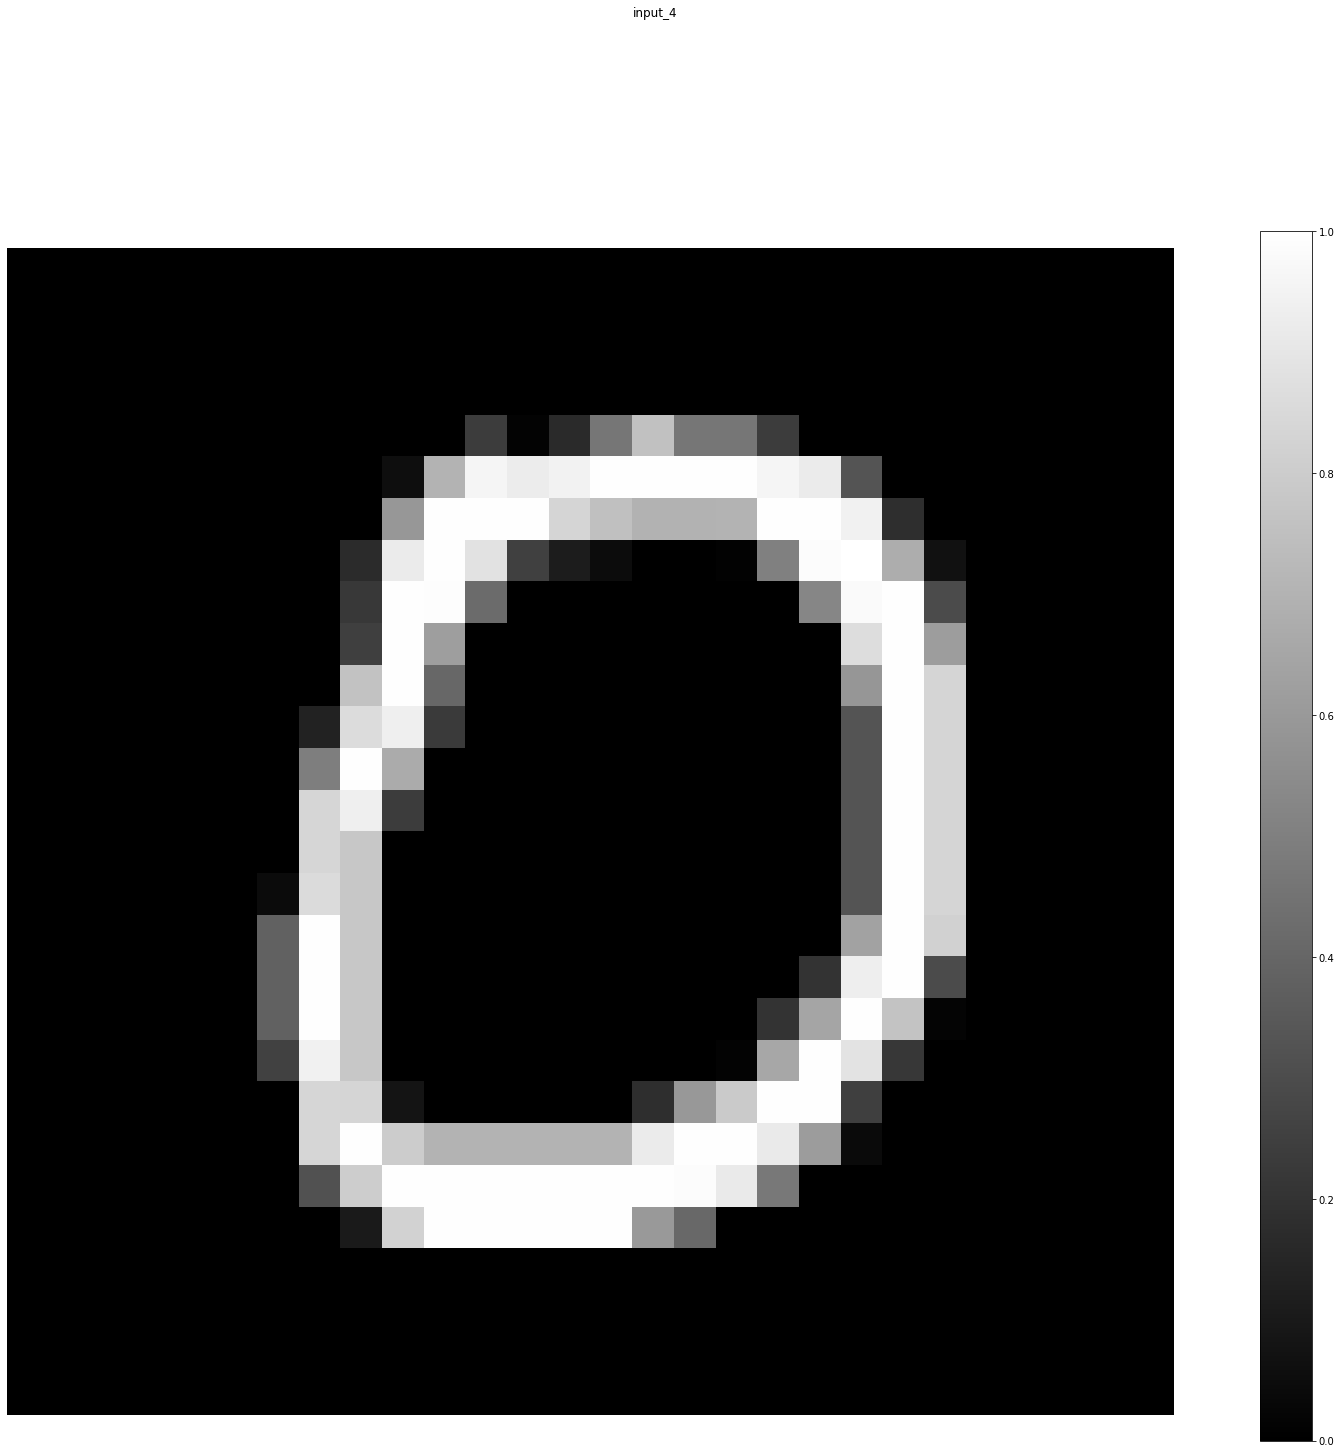

conv2d_7 (1, 26, 26, 32) 


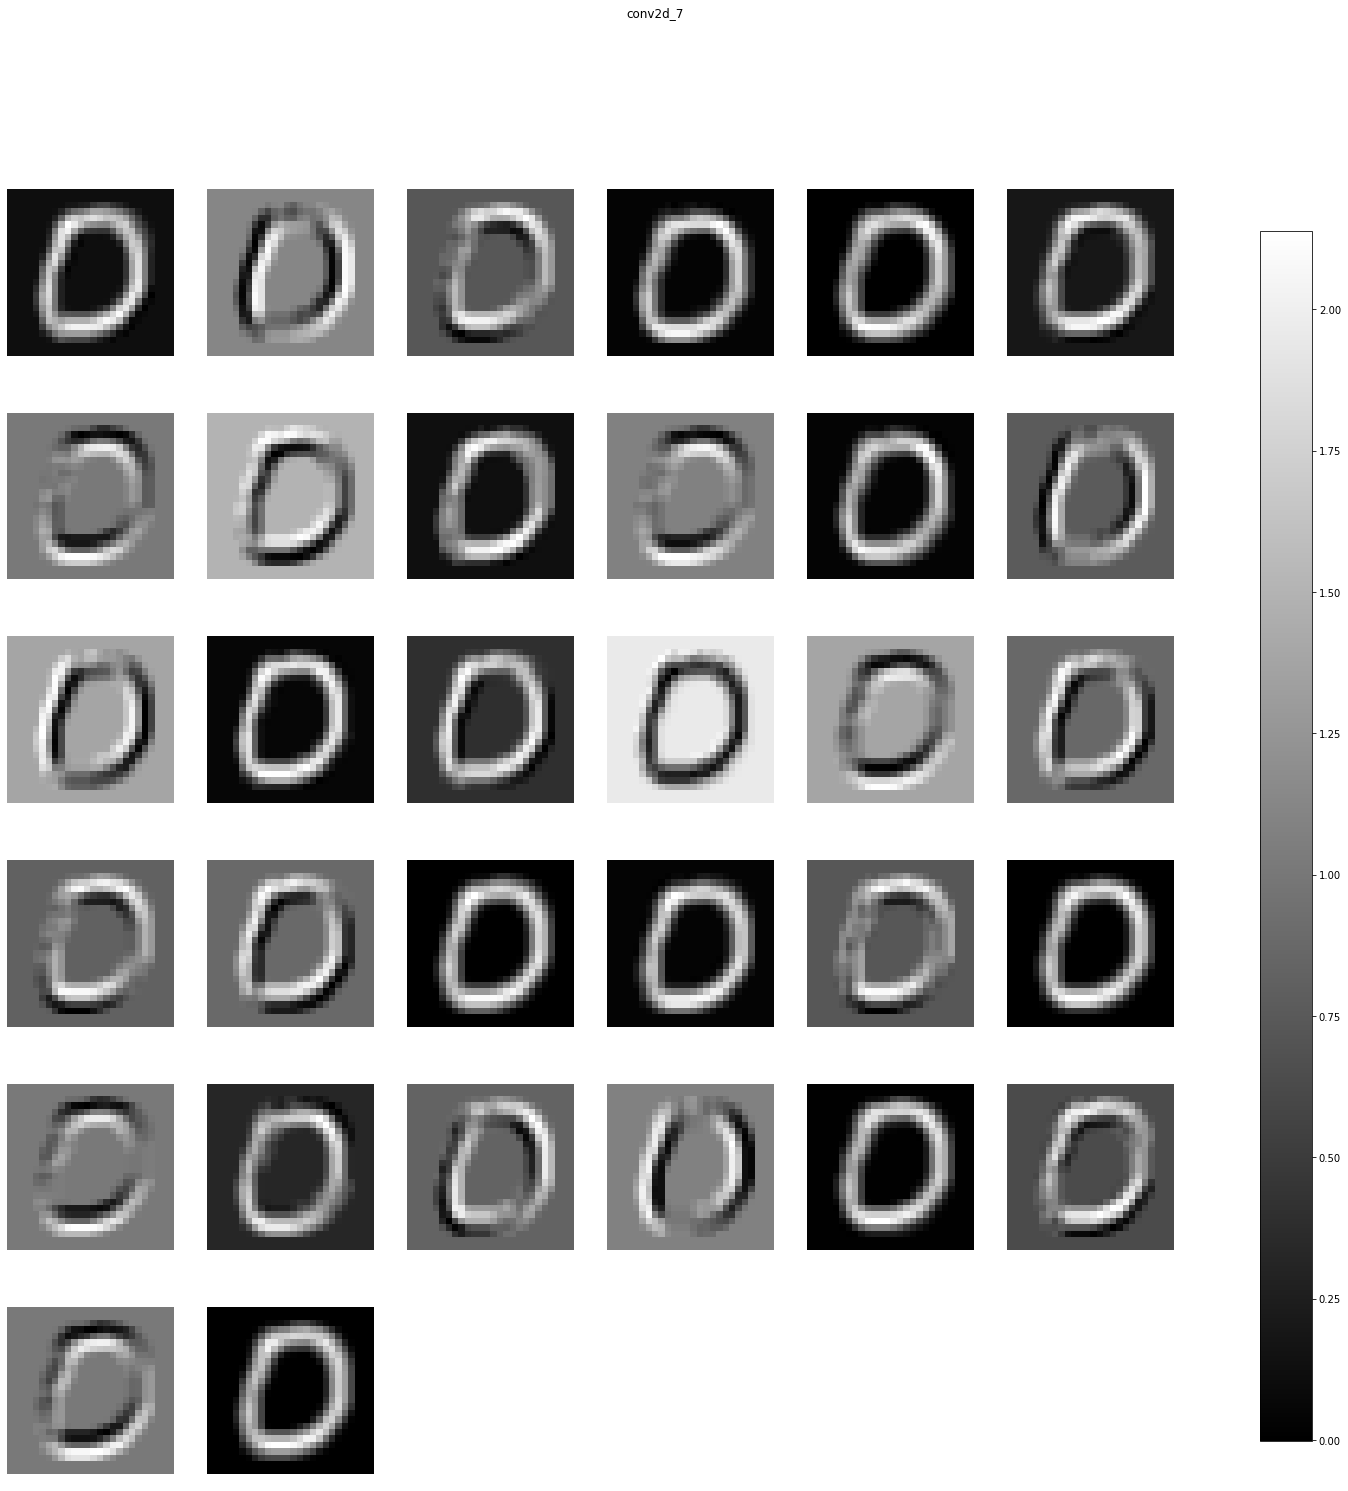

nsl_23 (1, 26, 26, 32) 


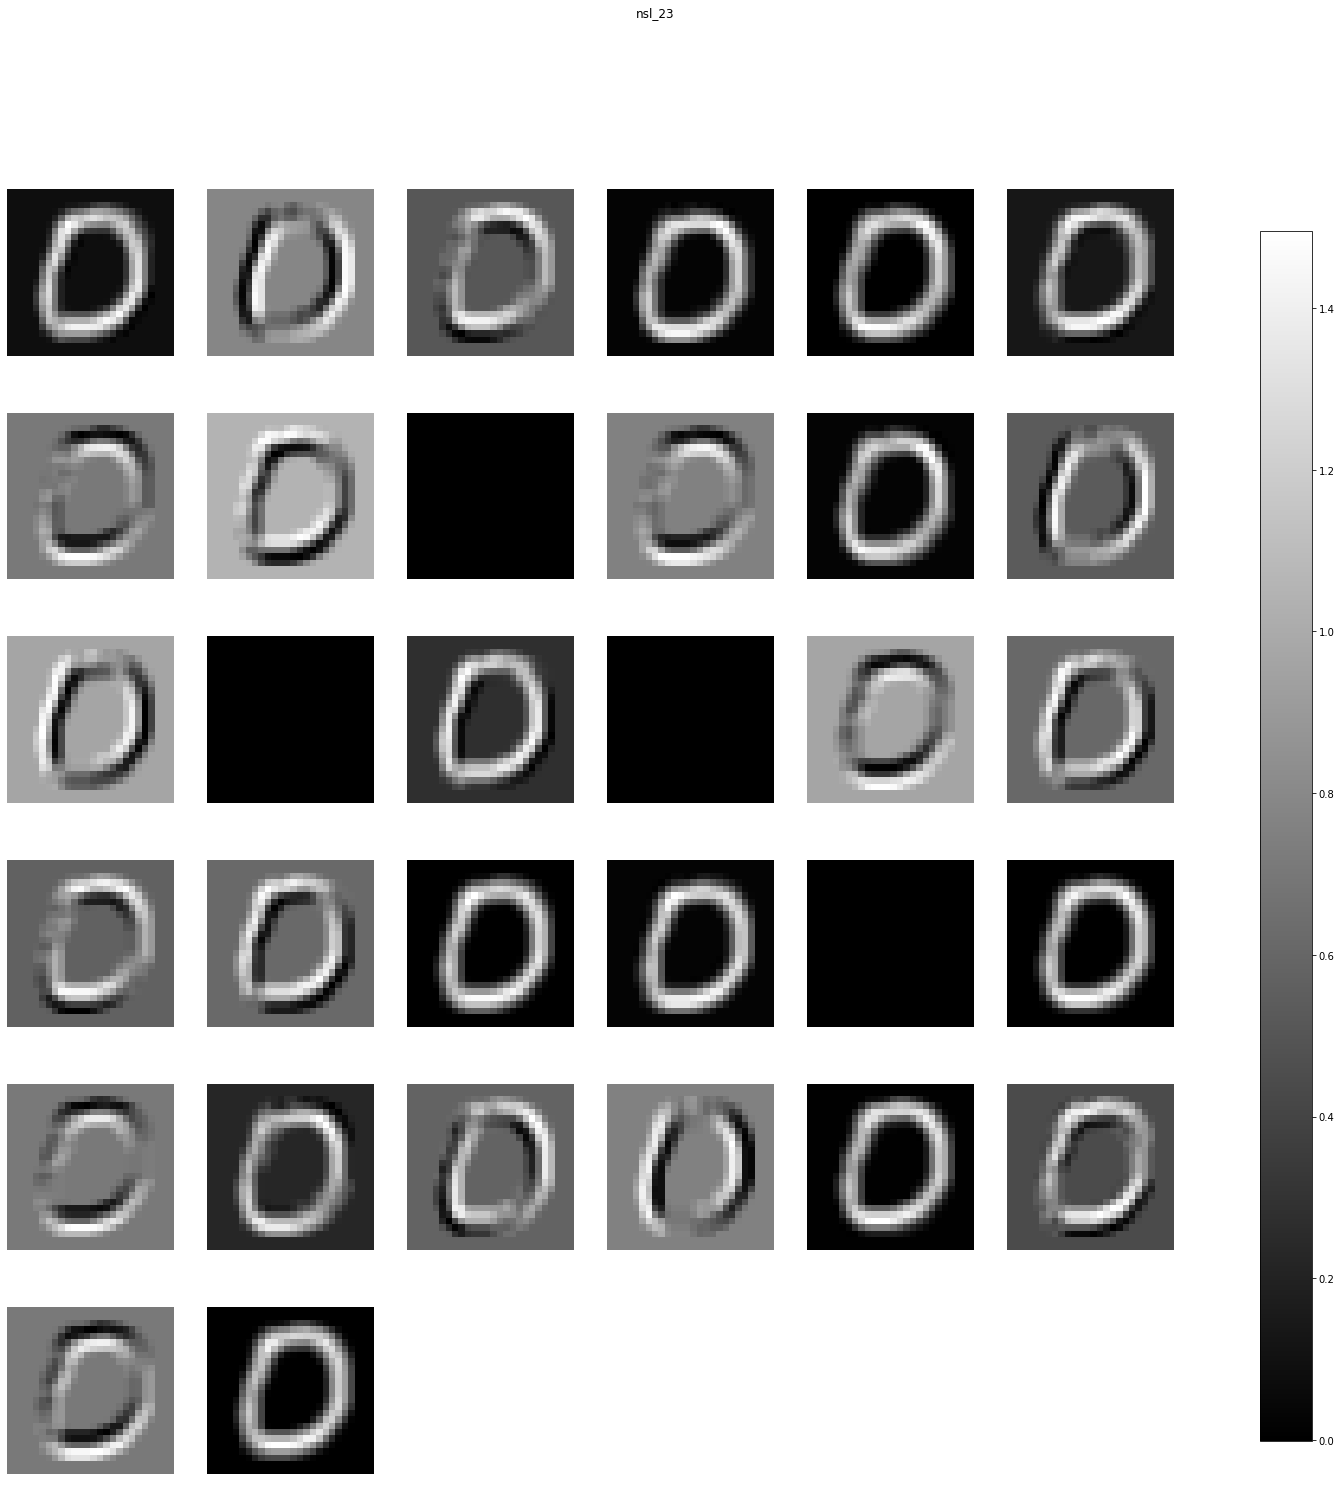

re_lu_10 (1, 26, 26, 32) 


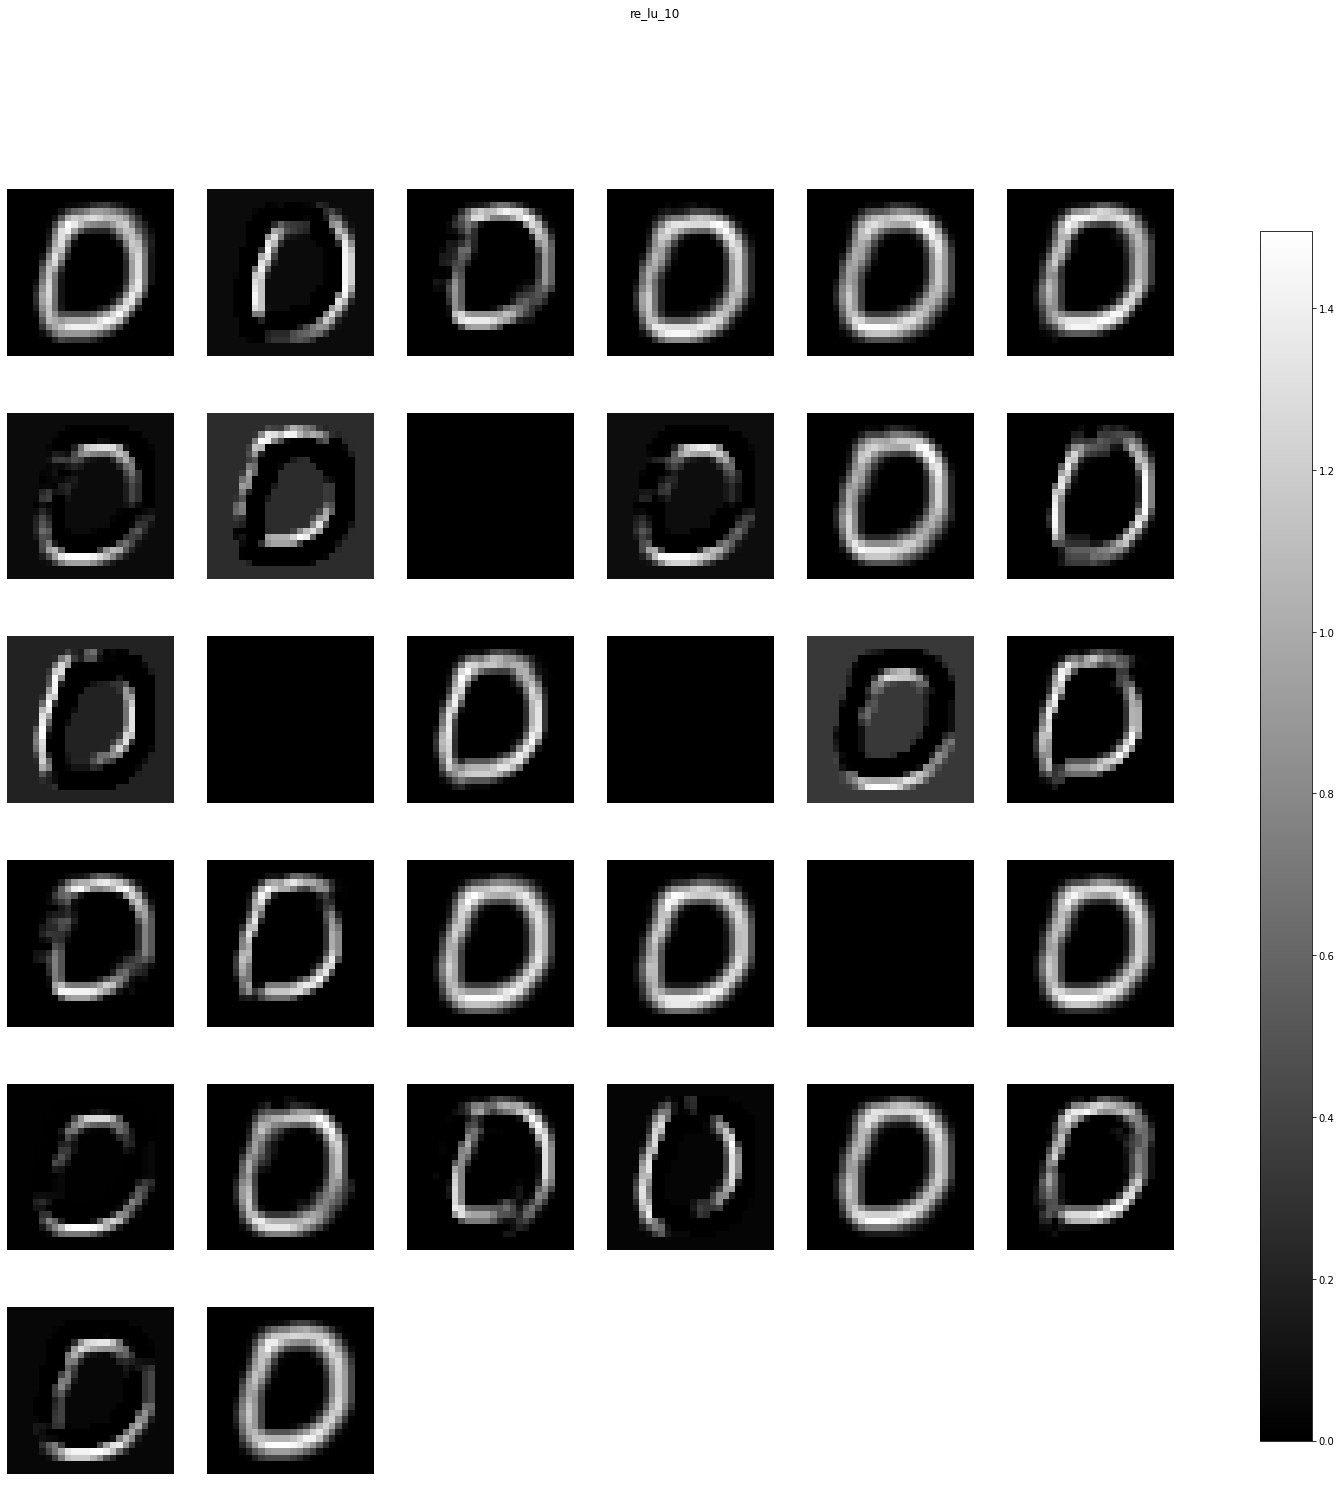

max_pooling2d_6 (1, 13, 13, 32) 


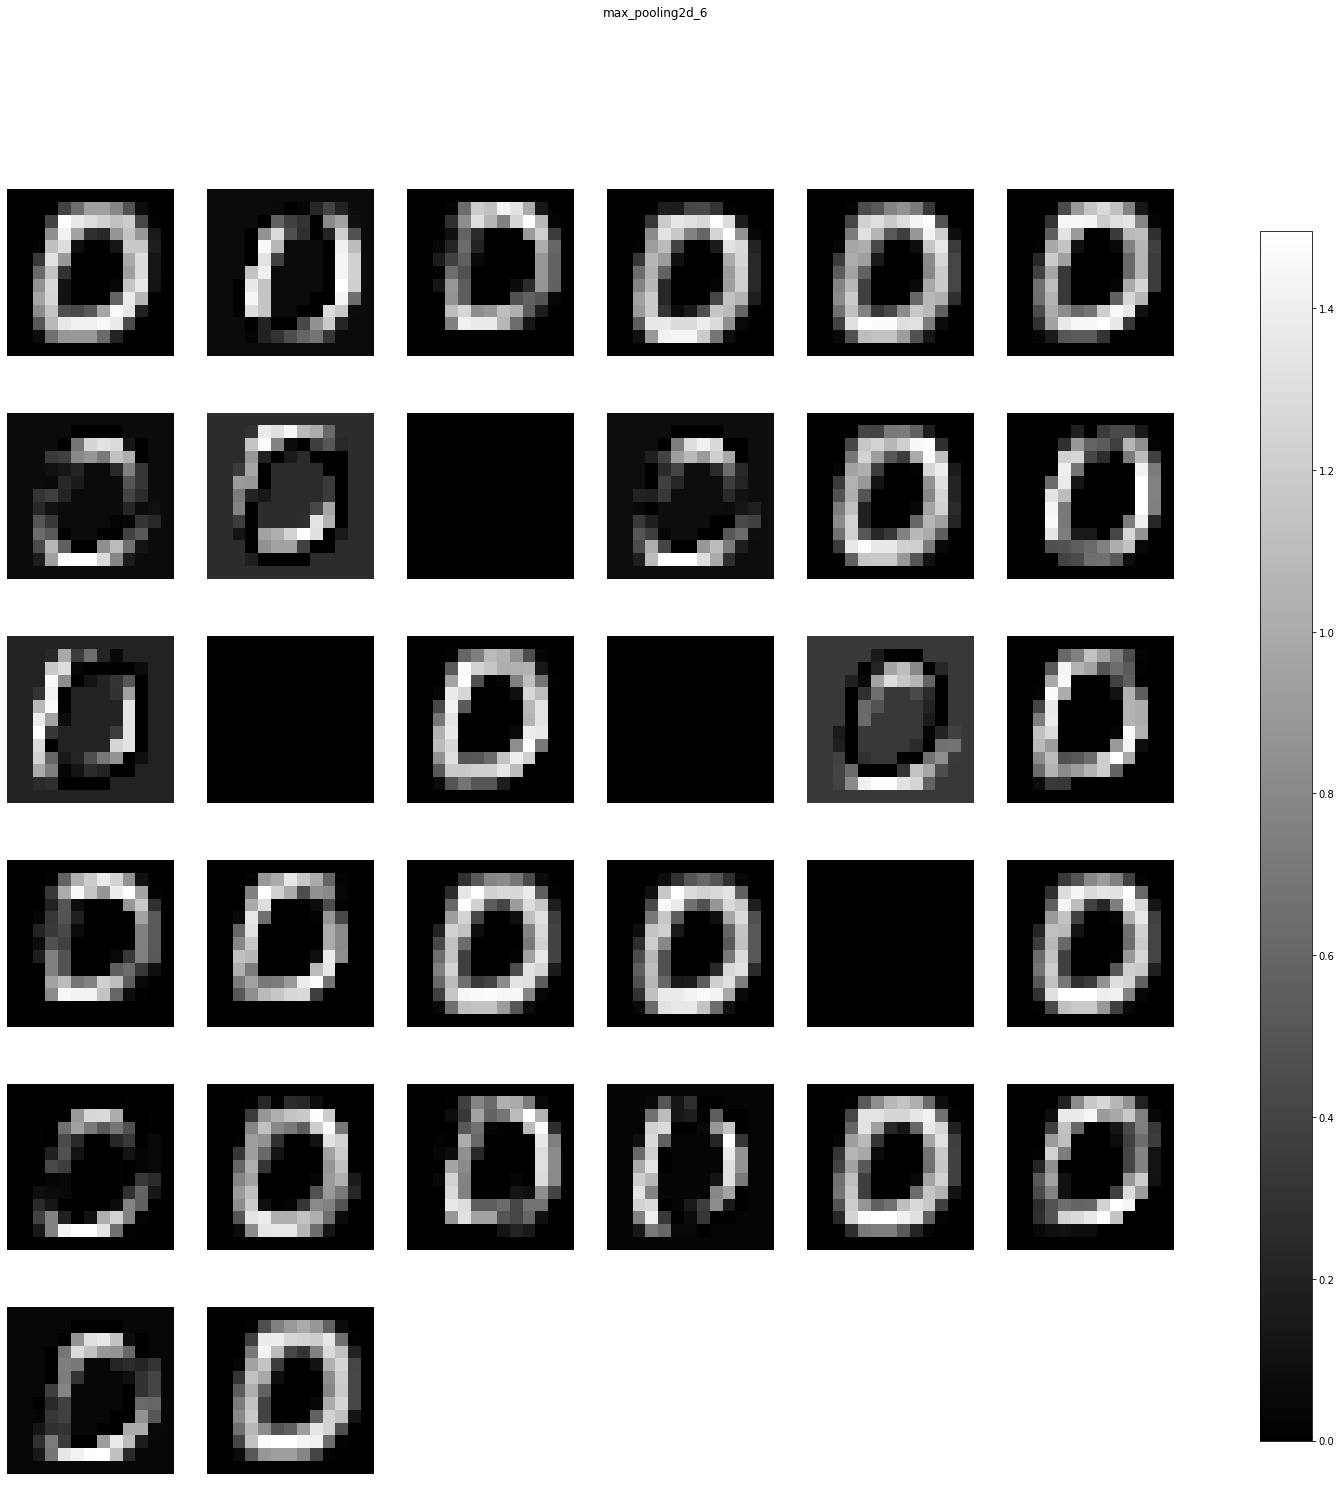

conv2d_8 (1, 11, 11, 64) 


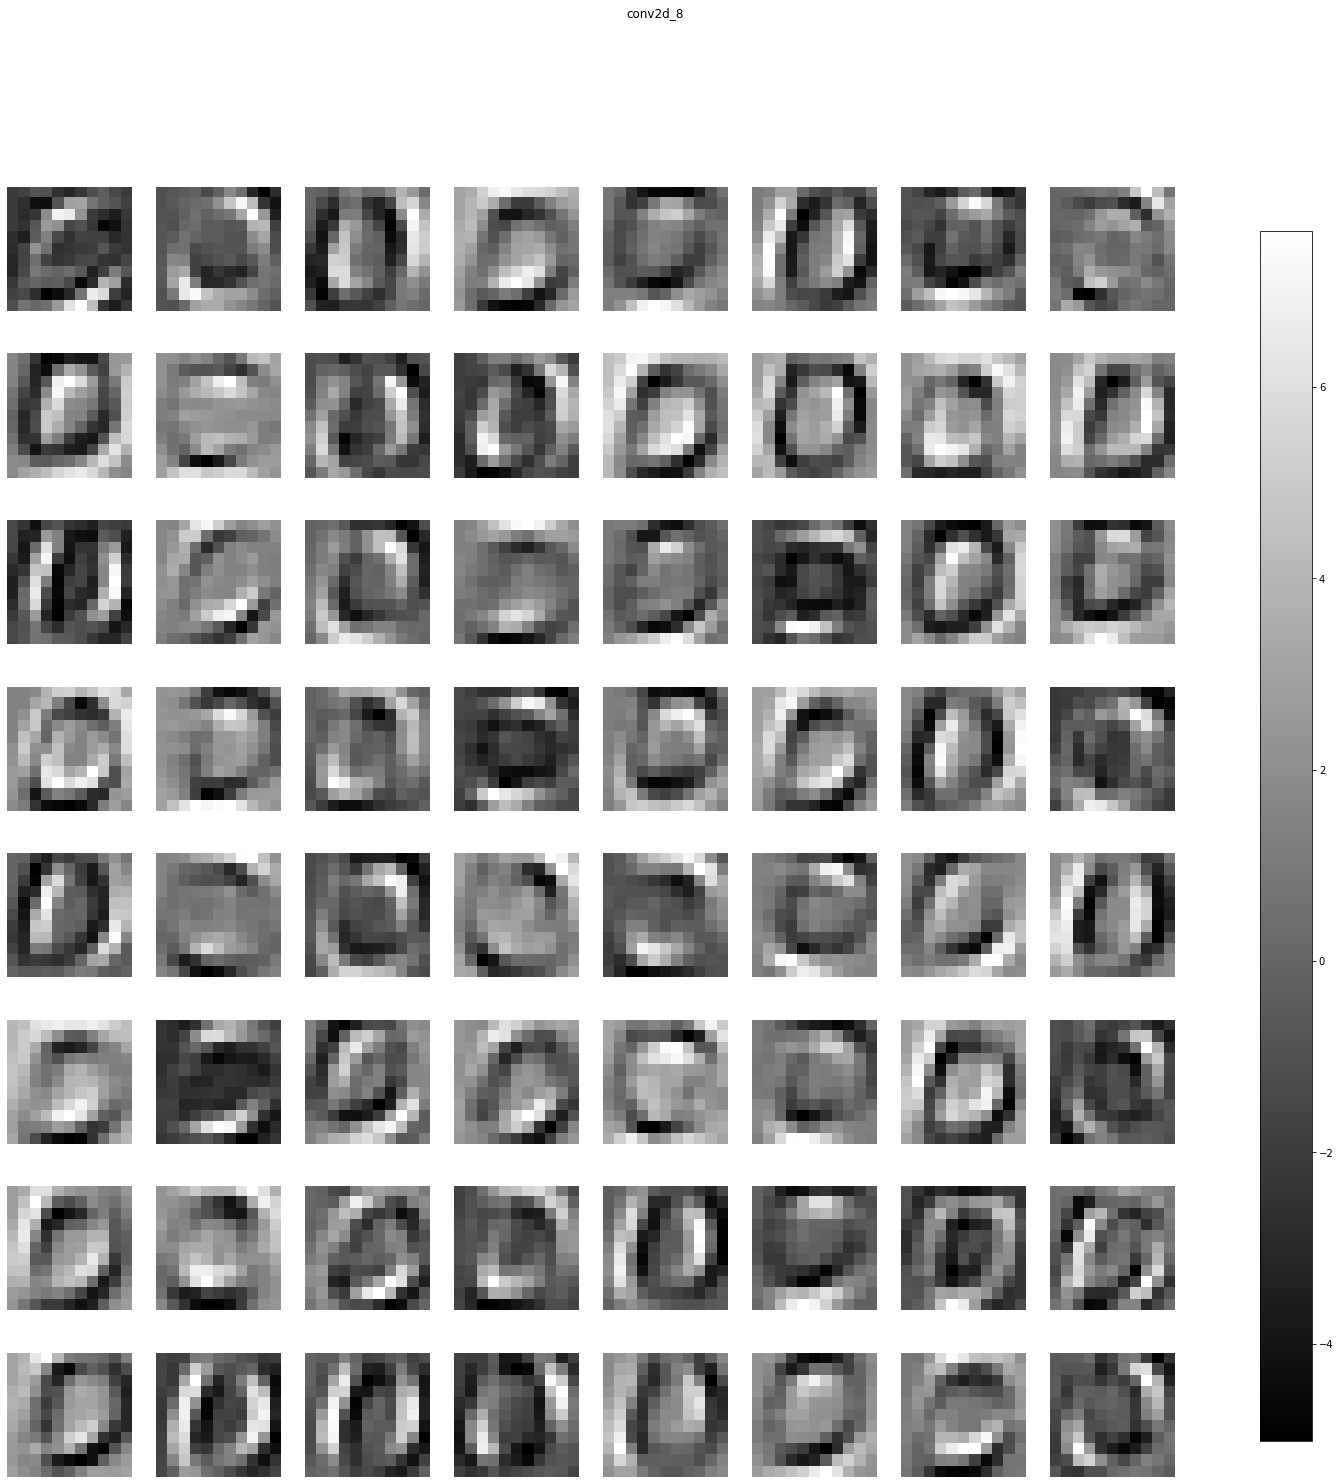

re_lu_11 (1, 11, 11, 64) 


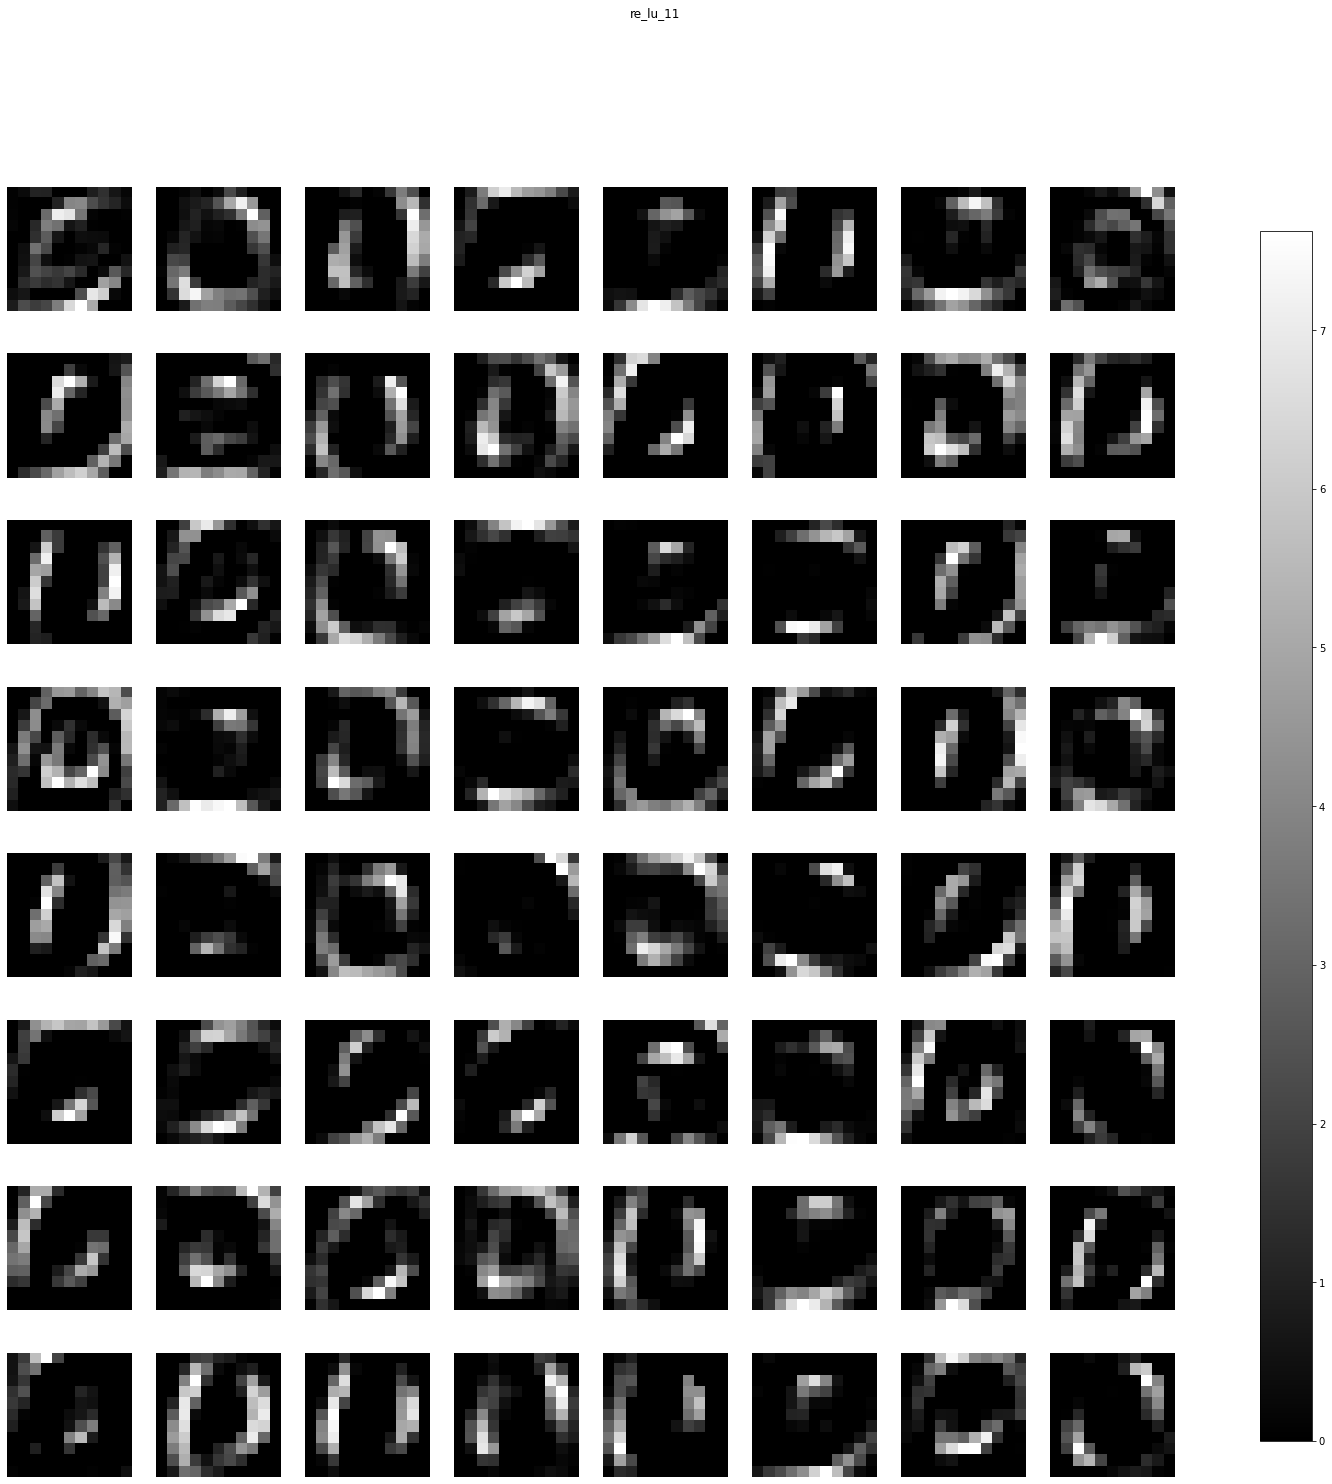

max_pooling2d_7 (1, 5, 5, 64) 


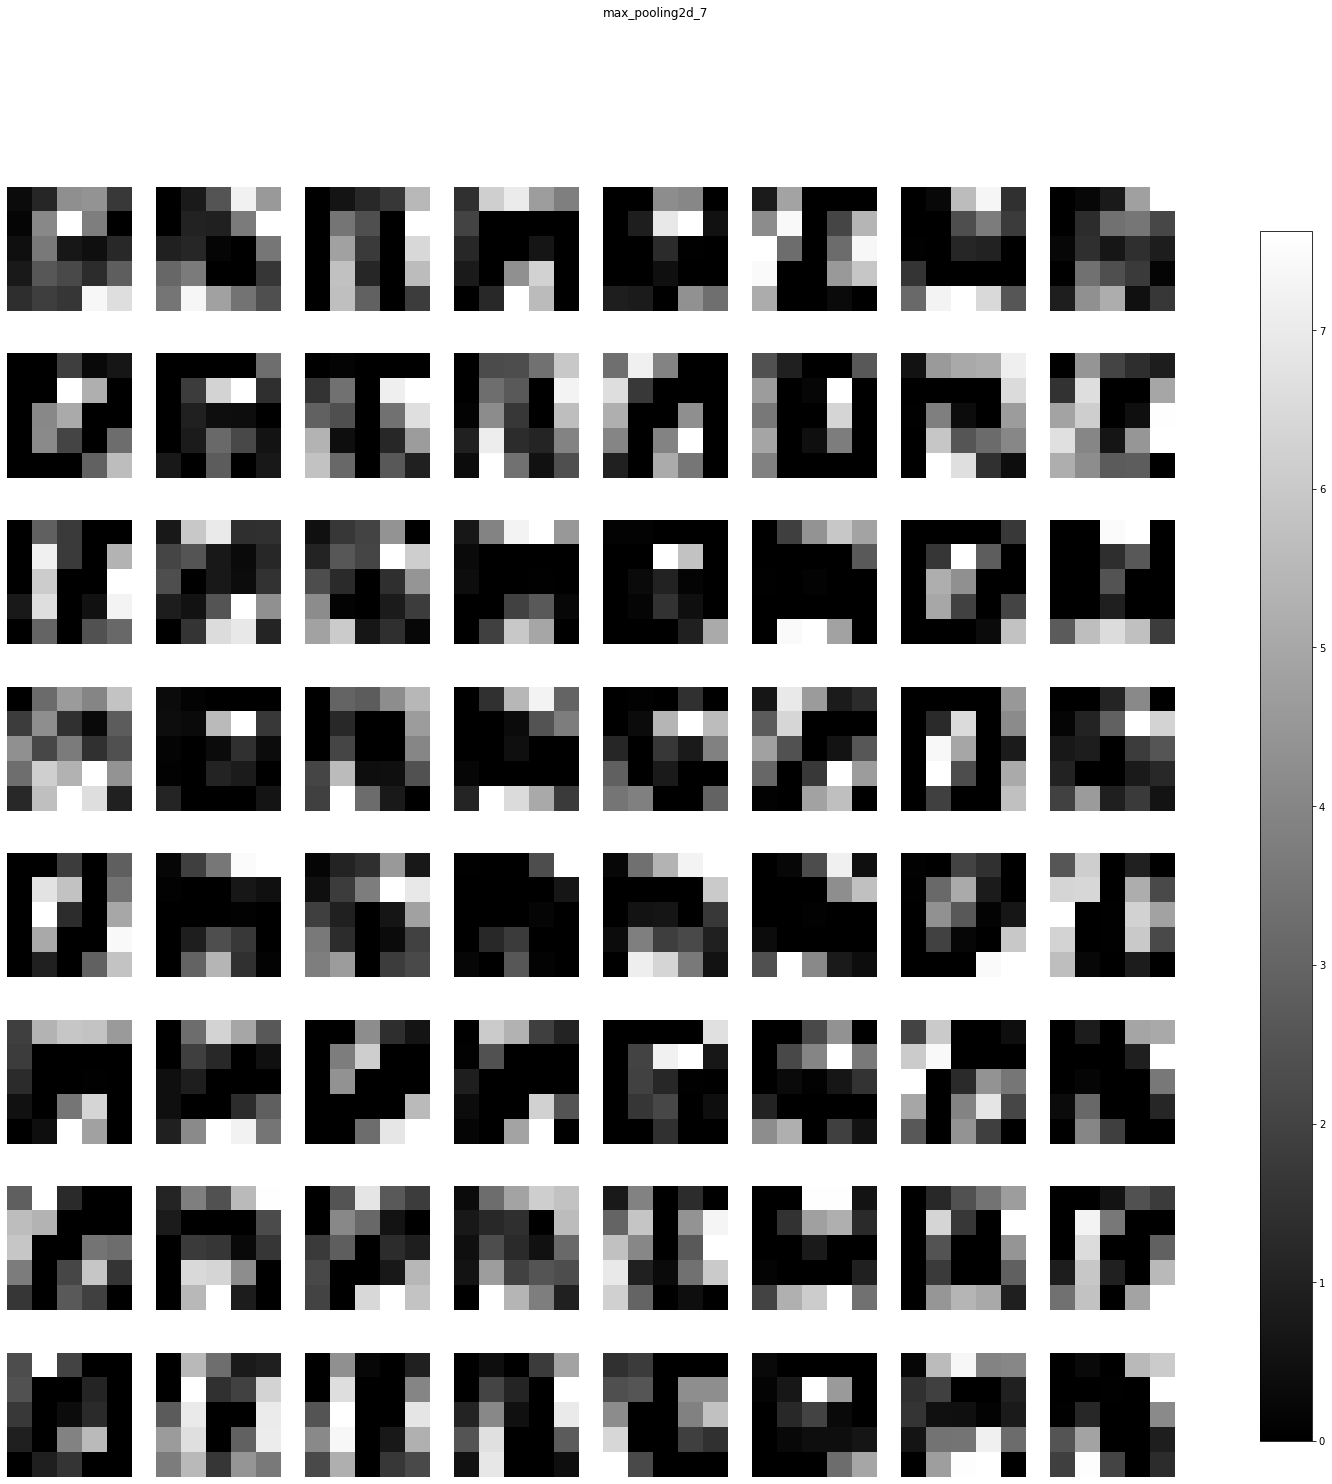

flatten_2 (1, 1600) 


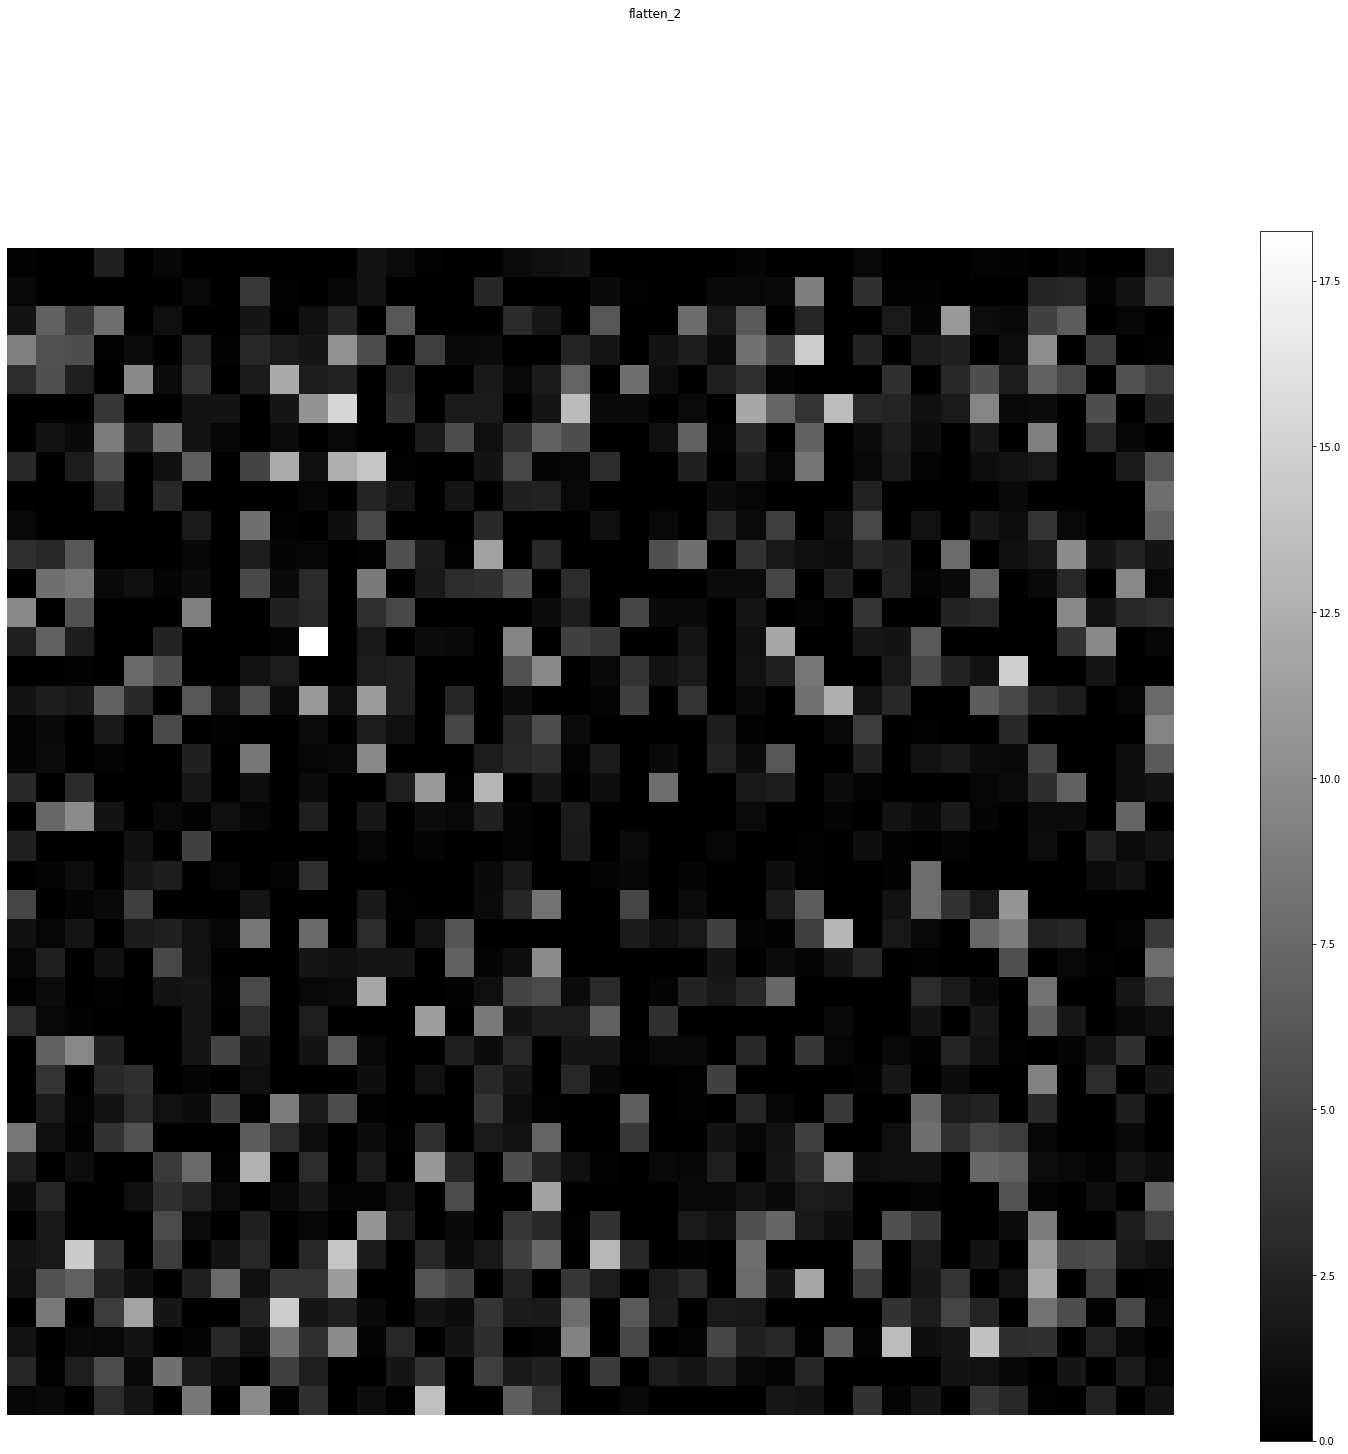

nsl_24 (1, 1600) 


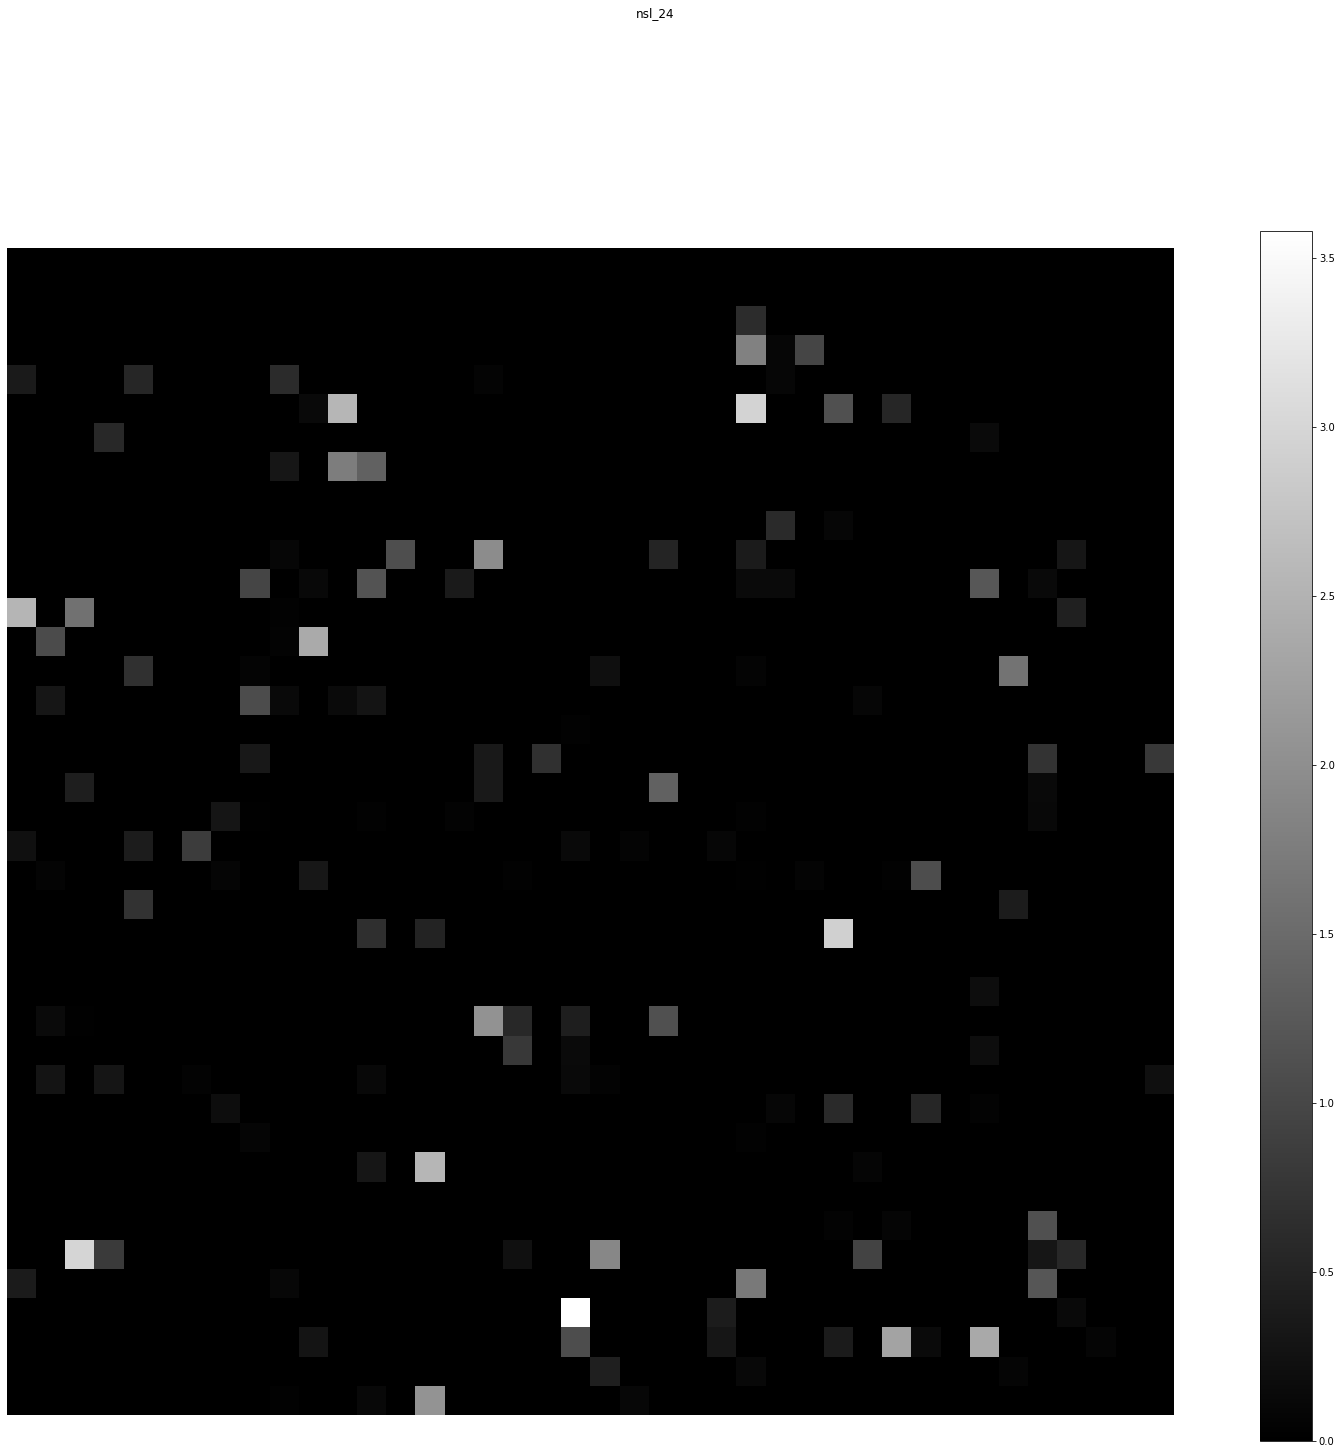

dense_6 (1, 128) 


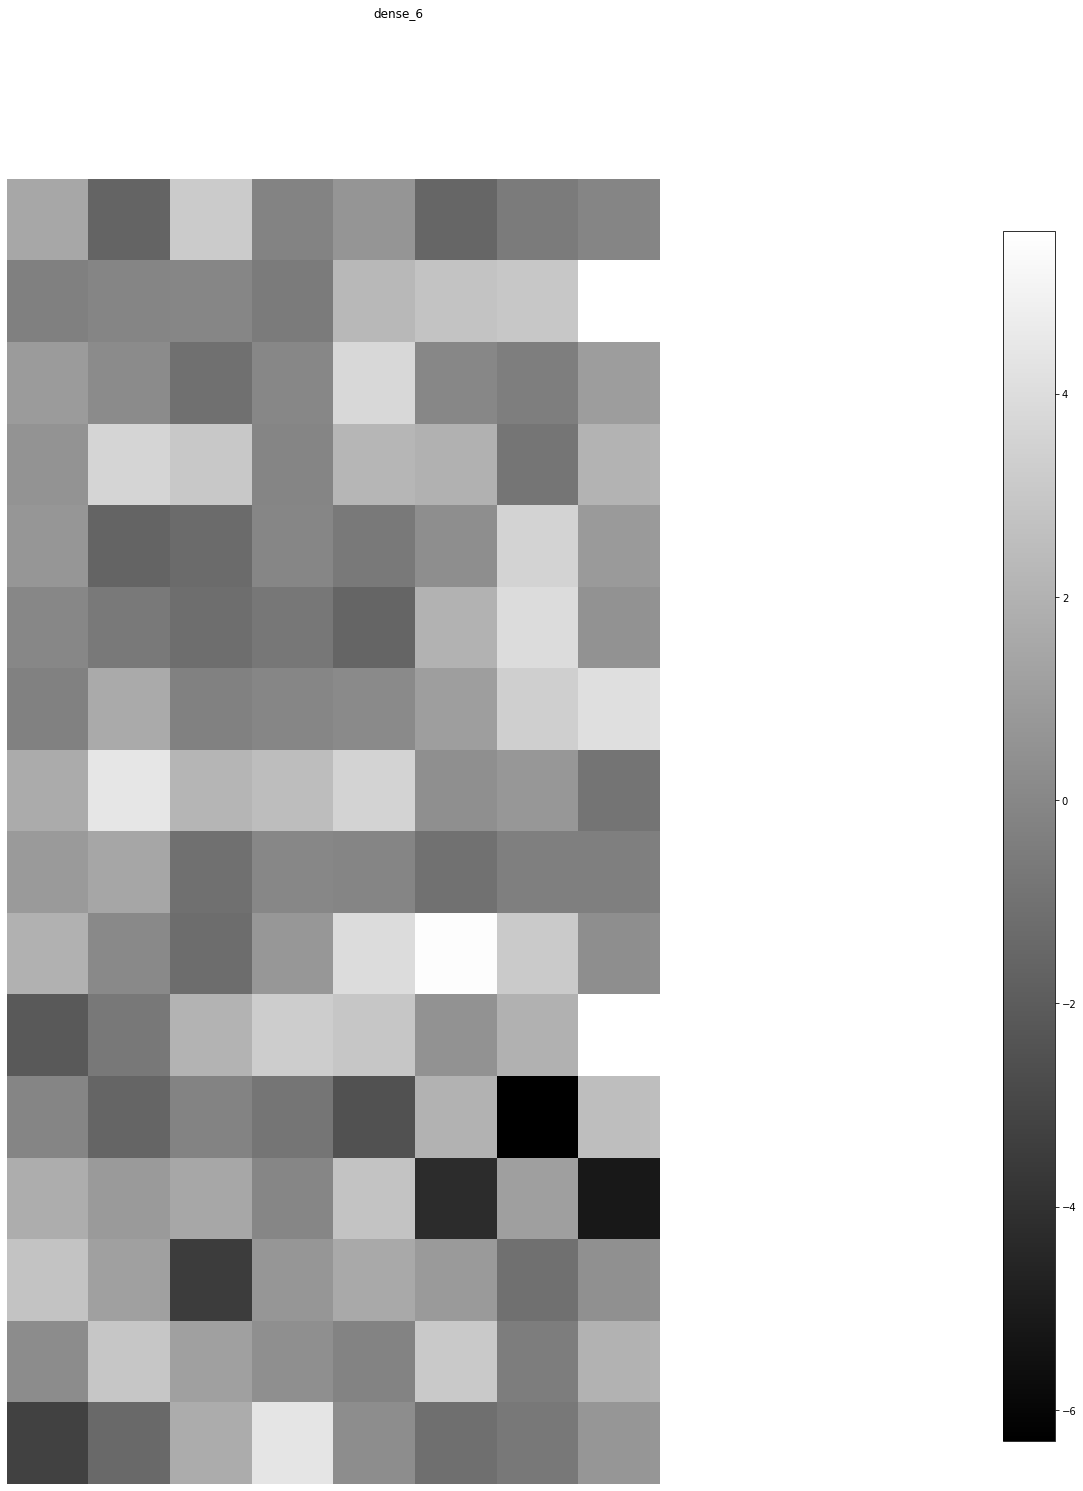

nsl_25 (1, 128) 


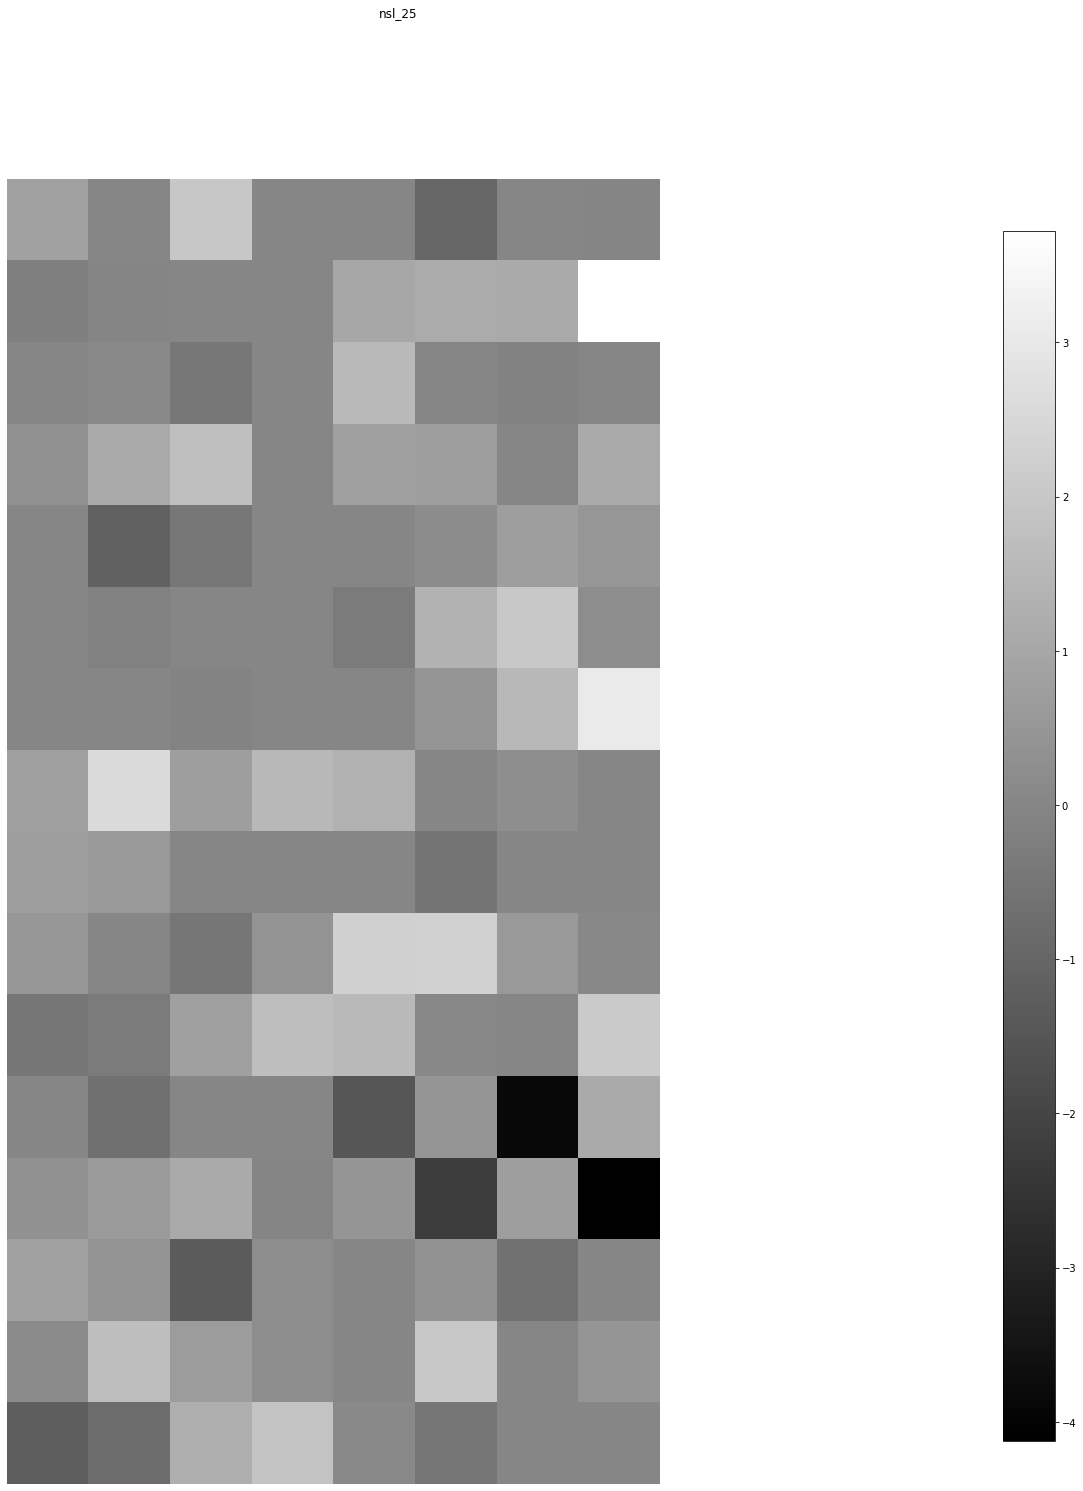

re_lu_12 (1, 128) 


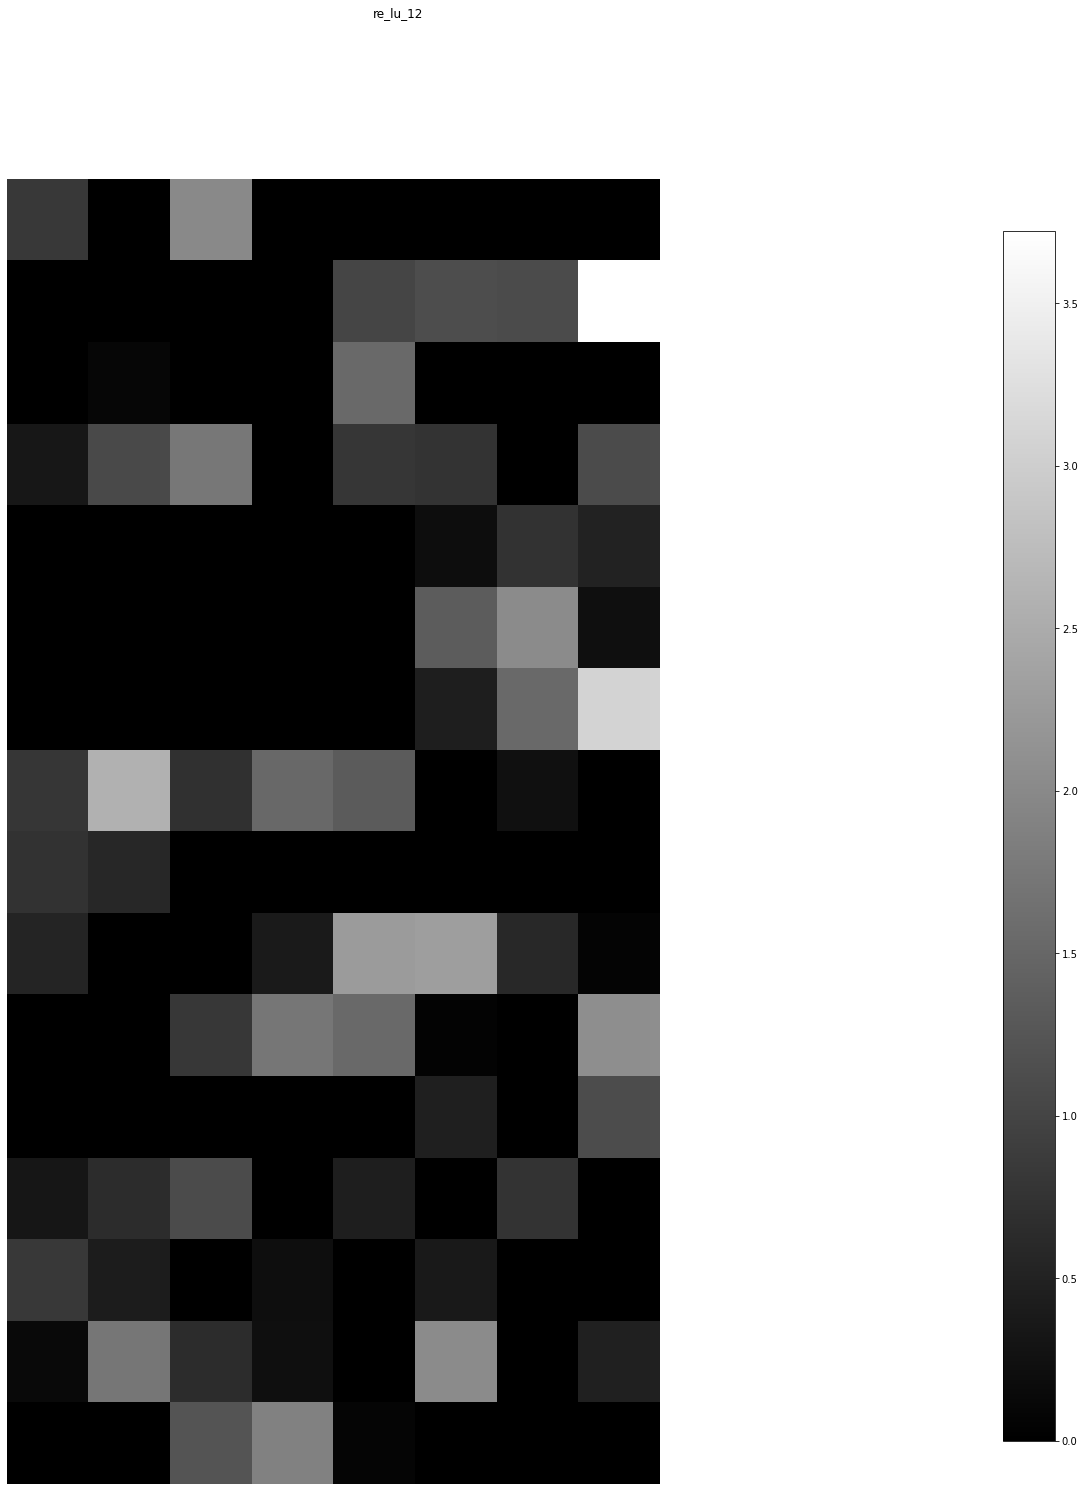

dense_7 (1, 128) 


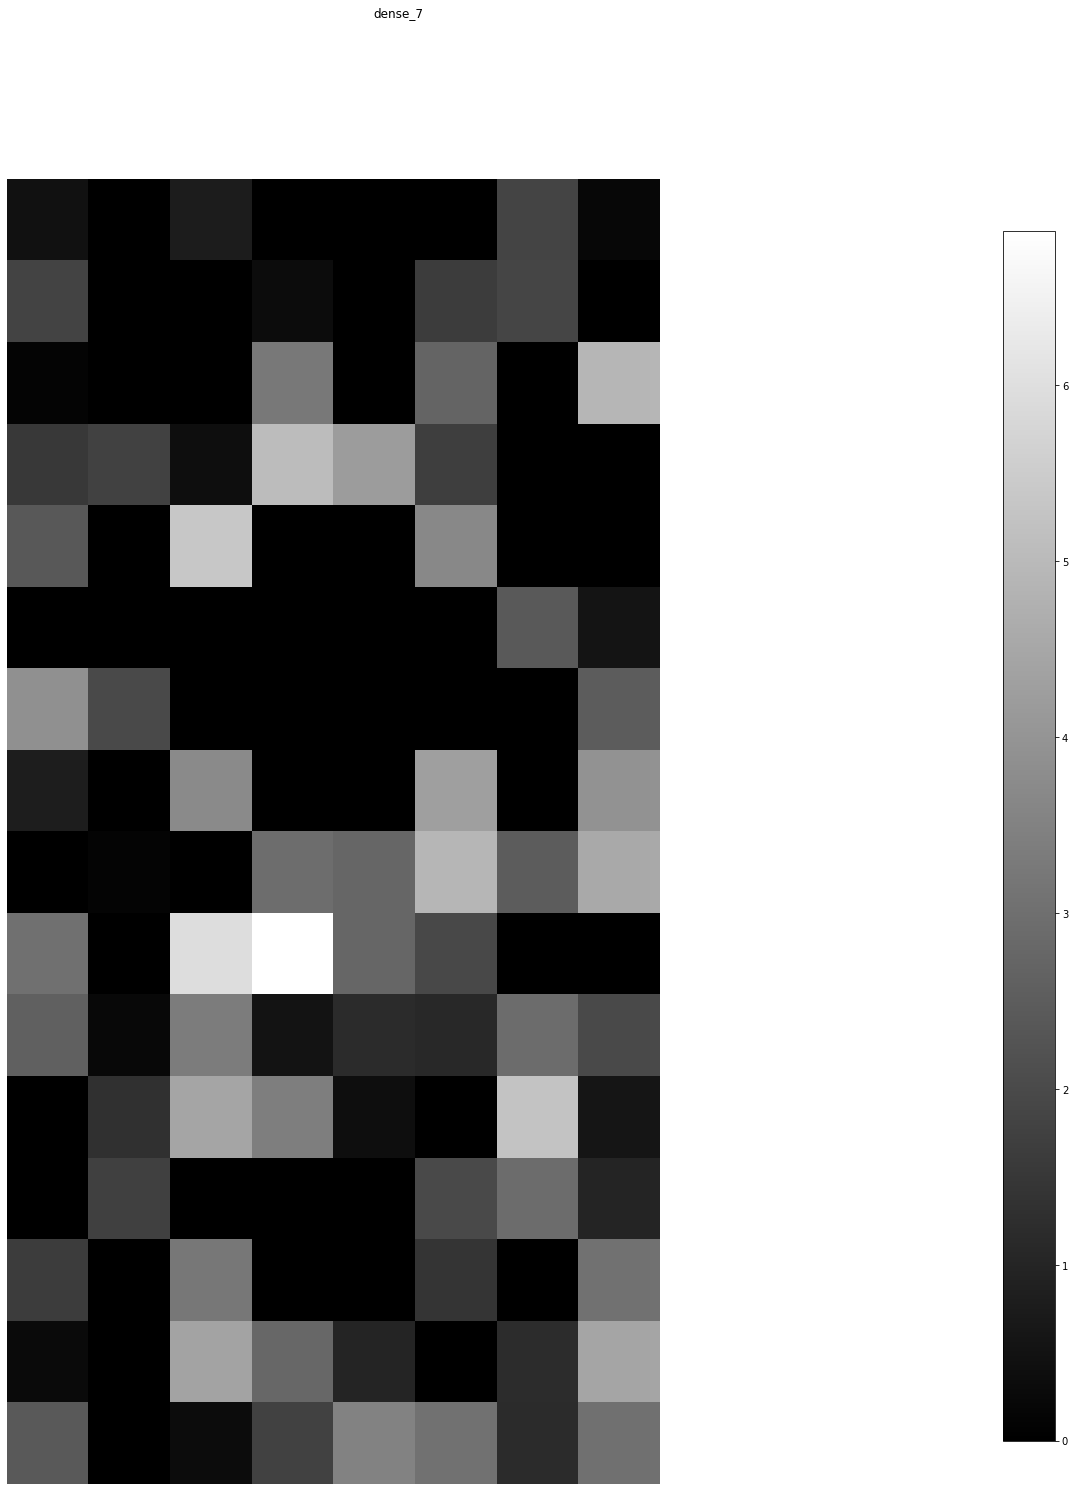

nsl_26 (1, 128) 


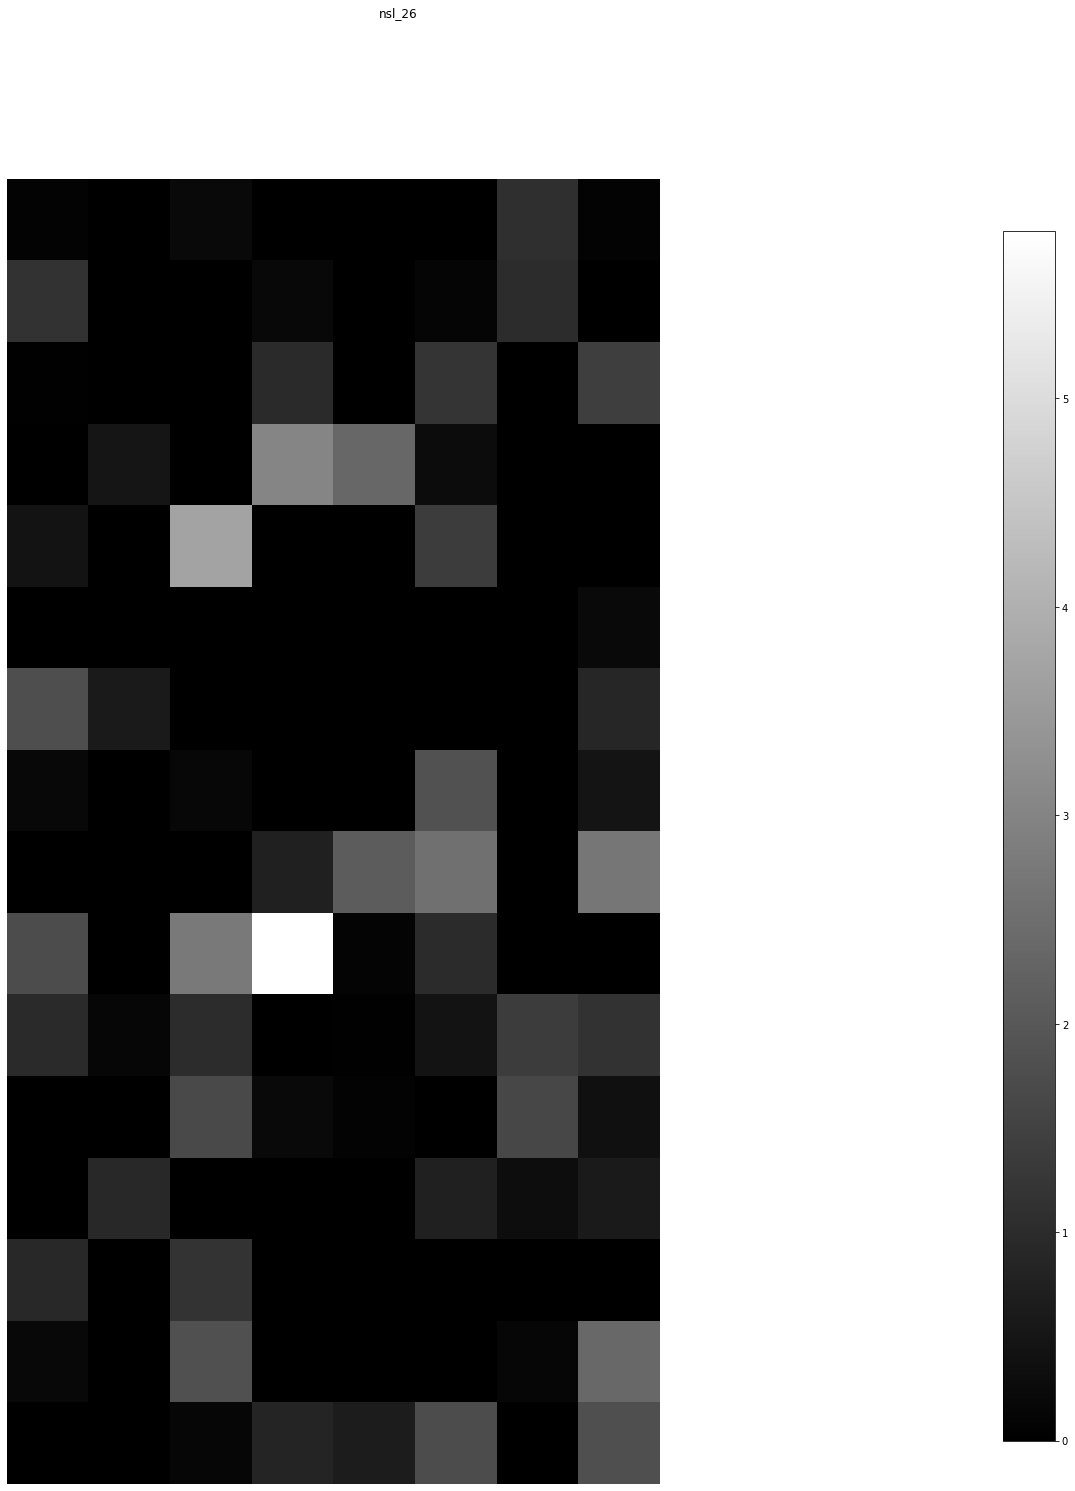

re_lu_13 (1, 128) 


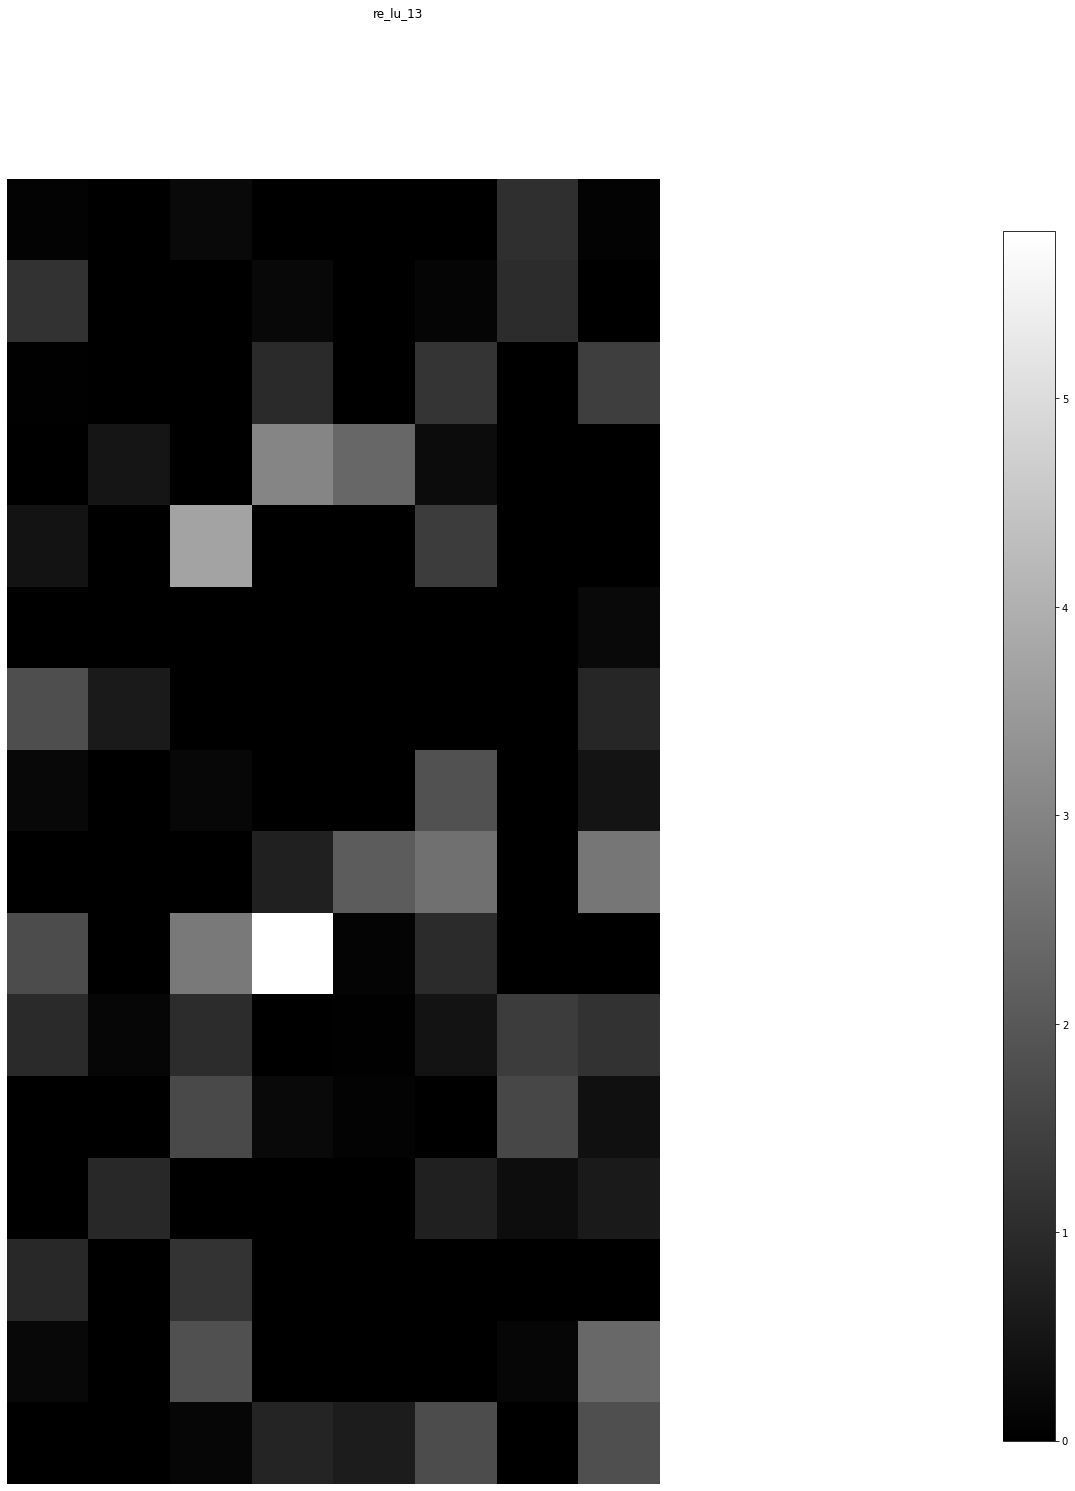

dense_8 (1, 10) 


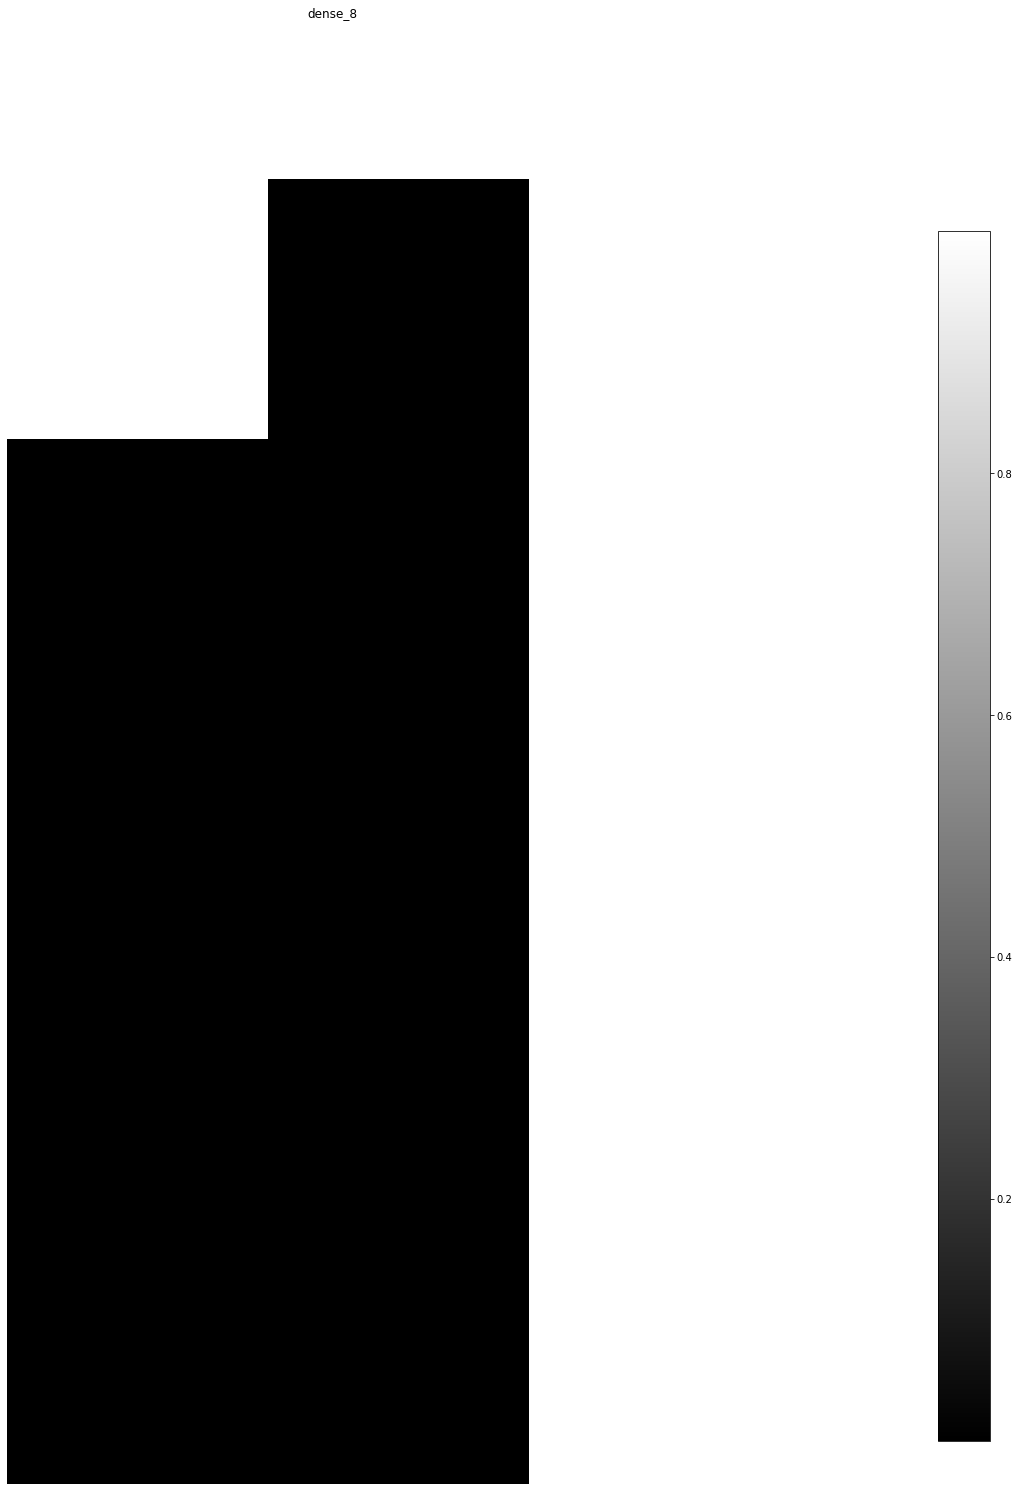

In [ ]:
# !pip install keract
from keract import get_activations, display_activations
keract_inputs = x_test[10:11]
# keract_targets = target_test[:1]
activations = get_activations(model_cloned, keract_inputs)
display_activations(activations, save=False, reshape_1d_layers=True, cmap='gray')

In [ ]:
# NOT WORKING: THIS IS THE ACTUAL PHYSICAL REMOVAL OF NEURONS
# Actual trimming and reduction of size
# Assumes no NSL before flatten, Dense after Flatten, and only Conv2D and Dense are supported to be with NSL
def build_layer(current_layer, current_model, units=None):
    the_layer = None
    weights = None
    biases = None
    print(current_layer)
    
    if isinstance(current_layer, layers.Conv2D) and (units is not None):
        current_model = keras.layers.Conv2D(units.shape[0], kernel_size=current_layer.kernel_size,
                                        activation=current_layer.activation)(current_model)
        weights = current_layer.get_weights()[0][:,:,:,units]        
        biases = current_layer.get_weights()[1][units]
        print(weights.shape)

    else:
        if isinstance(current_layer, layers.Dense) and (units is not None):
            current_model = keras.layers.Dense(units.shape[0], activation=current_layer.activation)(current_model)
            weights = current_layer.get_weights()[0][units]
#             print(weights.shape)
            biases = current_layer.get_weights()[1][units]
#             print(biases.shape)
            
        else:
            current_model = current_layer.__class__.from_config(current_layer.get_config())(current_model)
            weights = current_layer.get_weights()
            if len(weights) > 0:
                biases = current_layer.get_weights()[1]

    return current_model, weights, biases


inputs = keras.layers.Input(shape=input_shape)
current_model = inputs
# x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
built_net = False
threshold = trimming_threshold
all_ws = model.get_weights()
newWeightList = []

for l in range(len(model.layers) - 1):   
    current_layer = model.layers[l]
    next_layer = model.layers[l+1]
    print(current_layer.name)

    if isinstance(current_layer, NSL): # Remove NSL layers
        continue        
    
    if isinstance(current_layer, layers.InputLayer): # Just keep this as it is
        continue
    
    if isinstance(current_layer, layers.Flatten) and isinstance(next_layer, NSL): # Use CompressFlatten class to compress flatten layers
        current_model = current_layer.__class__.from_config(current_layer.get_config())(current_model) # Copy flatten layer
        # weights = current_layer.get_weights()
        continue

    if isinstance(current_layer, layers.Dense) and isinstance(next_layer, NSL): 
        # Neurons in the current layer would be trimmed according to the weights in the NSL layer next to it
        ws = next_layer.get_weights()[0]
        indices_to_keep = np.where(abs(ws)>=trimming_threshold)[0]

        new_layer = keras.layers.Dense(indices_to_keep.shape[0], activation=current_layer.activation)
        current_model = new_layer(current_model)

        weights = current_layer.get_weights()[0][:, indices_to_keep]
        biases = current_layer.get_weights()[1][indices_to_keep]
        print(weights)
        new_layer.set_weights([weights, biases])        

        # print(weights.shape)
        # newWeightList.append(weights)
        # Append the new weight list with our sparsified bias weights
        # newWeightList.append(biases)

        continue

    if isinstance(current_layer, layers.Conv2D) and isinstance(next_layer, NSL): 
        ws = next_layer.get_weights()[0]
        indices_to_keep = np.where(abs(ws)>=trimming_threshold)[0]

        new_layer = keras.layers.Conv2D(indices_to_keep.shape[0], kernel_size=current_layer.kernel_size,
                                        activation=current_layer.activation)
        current_model = new_layer(current_model)
        weights = current_layer.get_weights()[0][:,:,:,indices_to_keep]        
        biases = current_layer.get_weights()[1][indices_to_keep]

        new_layer.set_weights([weights, biases])  

        # print(weights.shape)
        # newWeightList.append(weights)
        # # Append the new weight list with our sparsified bias weights
        # newWeightList.append(biases)

        continue
    
    new_layer = current_layer.__class__.from_config(current_layer.get_config())
    current_model = new_layer(current_model)

    weights = current_layer.get_weights()  
    biases = []
    if len(weights) > 0:
        # newWeightList.append(weights[0])
        biases = weights[1]
        # newWeightList.append(biases)
        new_layer.set_weights([weights[0], biases])
    
    


current_layer = model.layers[-1]
current_model, ws, bs = build_layer(current_layer, current_model)
newWeightList.append(ws)
        
# Append the new weight list with our sparsified bias weights
newWeightList.append(bs)
    
model2 = Model(inputs=[inputs],outputs=[current_model])   
# model2.set_weights(newWeightList)

model2.summary()


input_52
conv2d_47
nsl_18
re_lu_9
max_pooling2d_6
conv2d_48


ValueError: ignored

In [ ]:
model2.layers[8].get_weights()

[array([[-0.02895454, -0.02463328,  0.00964963, ..., -0.01220251,
         -0.00771907,  0.00775115],
        [ 0.0214486 ,  0.01004943,  0.06666191, ...,  0.04407688,
         -0.01508951, -0.05085446],
        [-0.07542598,  0.01191037,  0.01121551, ...,  0.00974657,
          0.00251003, -0.00928916],
        ...,
        [ 0.00920593, -0.06717283, -0.00932135, ..., -0.04561407,
          0.09944273,  0.02751794],
        [-0.02082664, -0.09487423, -0.09315011, ..., -0.0398021 ,
         -0.00121584,  0.00771366],
        [-0.08467006,  0.09929226, -0.10167944, ..., -0.12786463,
         -0.05055297,  0.04410986]], dtype=float32),
 array([ 0.005426  ,  0.02099917,  0.05814148,  0.01725162, -0.02143651,
        -0.00157435, -0.01374769,  0.04859484,  0.02366389,  0.05425266,
        -0.00879377, -0.01789035,  0.04629609,  0.04041431,  0.01899443,
         0.04086782,  0.02657518,  0.01546485, -0.0280921 ,  0.06465711,
        -0.02996951,  0.08198204, -0.0097654 , -0.00114272,  0.043

In [ ]:
# model2.layers[8].set_weights(model2.layers[8].get_weights())
for l in newWeightList:
    print(l.shape)

(3, 3, 1, 32)
(32,)
(3, 3, 32, 64)
(64,)
(99, 128)
(99,)


AttributeError: ignored

In [ ]:
newWeightList[5]

array([ 0.005426  ,  0.02099917,  0.05814148,  0.01725162, -0.02143651,
       -0.00157435, -0.01374769,  0.04859484,  0.02366389,  0.05425266,
       -0.00879377, -0.01789035,  0.04629609,  0.04041431,  0.01899443,
        0.04086782,  0.02657518,  0.01546485, -0.0280921 ,  0.06465711,
       -0.02996951,  0.08198204, -0.0097654 , -0.00114272,  0.0433756 ,
        0.0476503 ,  0.01919394,  0.05892349, -0.02927107,  0.03105676,
        0.00052445,  0.01517131, -0.0013184 ,  0.00146265,  0.05158474,
        0.00513646,  0.04715839, -0.00256595,  0.00217077, -0.0074035 ,
        0.04174229,  0.06531363,  0.01987978,  0.00018591,  0.02039207,
        0.06487513, -0.00789385, -0.01841593,  0.02608554,  0.03976482,
       -0.00455175,  0.07393536,  0.05106887,  0.02156482,  0.01472142,
        0.13083692,  0.0255474 ,  0.01724871,  0.01189607,  0.02827875,
       -0.00093915,  0.0350383 ,  0.03591885, -0.02164923,  0.01053873,
       -0.03143775,  0.02922552,  0.06368919,  0.06862999, -0.01

In [ ]:
for l in model.layers:
    ws = l.get_weights()
    if(len(ws) == 0):        
        print(l.name)
    if(len(ws) == 2):        
        print(l.name, ws[0].shape, ws[1].shape)
    if(len(ws) == 1):        
        print(l.name, ws[0].shape)


input_10
conv2d_8 (3, 3, 1, 32) (32,)
nsl_6 (32,)
re_lu_3
max_pooling2d_2
conv2d_9 (3, 3, 32, 64) (64,)
re_lu_4
max_pooling2d_3
flatten_1
nsl_7 (1600,)
dense_7 (1600, 128) (128,)
nsl_8 (128,)
re_lu_5
dense_8 (128, 10) (10,)


In [ ]:
l = model2.layers[8]
l.get_weights()

[array([[ 0.03468296,  0.02145528,  0.05375824, ..., -0.02545723,
         -0.01086837, -0.0438729 ],
        [ 0.05731425,  0.03655965,  0.02118937, ...,  0.04780157,
          0.04346022,  0.01605261],
        [-0.03042637, -0.02921392,  0.02016058, ..., -0.03738361,
          0.04409149,  0.01345651],
        ...,
        [-0.03584927, -0.01987287, -0.04095186, ..., -0.02748552,
          0.05216978, -0.00818924],
        [ 0.03606356, -0.03985491,  0.00380449, ...,  0.00318469,
          0.05794683, -0.04804903],
        [ 0.03771136,  0.03024045,  0.00701199, ..., -0.03929397,
         -0.02187249,  0.04765125]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
model2.layers

In [ ]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
evaluate_model(model2, x_test, x_train, y_test, y_train)

Test loss: 117.43372344970703
Test accuracy: 0.03739999979734421
Train loss: 116.51602172851562
Train accuracy: 0.03689999878406525
